In [1]:
#Import des librairies Python

import os
import pandas as pd
import numpy as np
import sqlite3
import matplotlib
from sqlalchemy import create_engine
from IPython.display import display, Markdown
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import math
from datetime import datetime
import xlrd
from sklearn import preprocessing
import seaborn as sns
from functions import *
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.cluster import hierarchy
from sklearn import cluster, metrics
from sklearn import decomposition
import matplotlib.patches as mpatches
import statsmodels.formula.api as smf
from sklearn.metrics import pairwise_distances_argmin_min
import scipy.stats as st
from collections import Counter
from tqdm import tqdm 
import pickle
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.float_format = '{:,.2f}'.format
cwd = os.getcwd()

# PROJET 8 - COVID Analysis

database : https://ourworldindata.org/covid-deaths (04/01/2021)



In [2]:
date = '2021-12-31'

In [3]:
#Création de la base de données SQL
bdd_engine = create_engine(f'sqlite:///{cwd}\CovidAnalysis.sqlite3')
#Chargement des données
covid_data = pd.read_csv(cwd + '/Data/covid_data.csv')

#création d'une boucle pour completer la colonne continent qui est vide pour quelques "localisations"

def traitement(row):
    if row['location'] == 'World':
        return 'World'
    elif row['location'] in ['Africa', 'Asia', 'Europe', 'South America', 'North America', 'Oceania']:
        return 'continent'
    elif row['location'] in ['High income', 'Low income', 'Upper middle income', 'Lower middle income']:
        return 'income'
    elif row['location'] in ['International']:
        return 'international'
    else:
        return row['continent']

covid_data['continent'] = covid_data.apply(traitement, axis=1)

# Delete these row indexes from dataFrame
ue_drop = covid_data[covid_data['location'] == 'European Union'].index
covid_data.drop(ue_drop , inplace=True)

#mise des df dans la bdd
covid_data.to_sql(name='covid_data', con=bdd_engine, if_exists='replace', index=False)
covid_data[covid_data['location'] == 'Brazil'].head(2)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,excess_mortality_cumulative,excess_mortality,excess_mortality_cumulative_per_million
19513,BRA,South America,Brazil,2020-02-26,1.00,1.00,nan,nan,nan,nan,...,10.10,17.90,nan,2.20,75.88,0.77,nan,nan,nan,nan
19514,BRA,South America,Brazil,2020-02-27,1.00,0.00,nan,nan,nan,nan,...,10.10,17.90,nan,2.20,75.88,0.77,nan,nan,nan,nan


In [4]:
#analyse de la quantité de pays dans la base
analyse = covid_data.copy()
analyse = analyse[(analyse['continent'] != 'continent')&(analyse["continent"]!= 'income')&(analyse["continent"] != 'World')&(analyse["continent"] != 'international')]
nbr_pays = analyse.copy()
nbr_pays['nbr'] = 1
nbr_pays = nbr_pays[['location', 'nbr']]
nbr_pays = nbr_pays[['location', 'nbr']].groupby('location').sum().reset_index()

print( "Notre base a " + str(nbr_pays['location'].count()) + " pays")
print( " ")
#analyse du nombre de cas et de morts par covid dans notre période d'analyse
analyse2 = covid_data.copy()
analyse2 = analyse2[(analyse2['continent'] != 'continent')&(analyse2["continent"]!= 'income')&(analyse2["continent"] != 'World')&(analyse2["continent"] != 'international')]
analyse2 = analyse2[(analyse2['date'] > '2020-01-01') & (analyse2['date'] < '2021-12-31')] 
print("Du 1er janvier 2020 au 31 décembre 2021, nous avons eu " + str(analyse2['new_cases'].sum()) + " cas de Covid-19 dans la planète et " + str(analyse2['new_deaths'].sum()) + " morts.")

Notre base a 225 pays
 
Du 1er janvier 2020 au 31 décembre 2021, nous avons eu 285929139.0 cas de Covid-19 dans la planète et 5405835.0 morts.


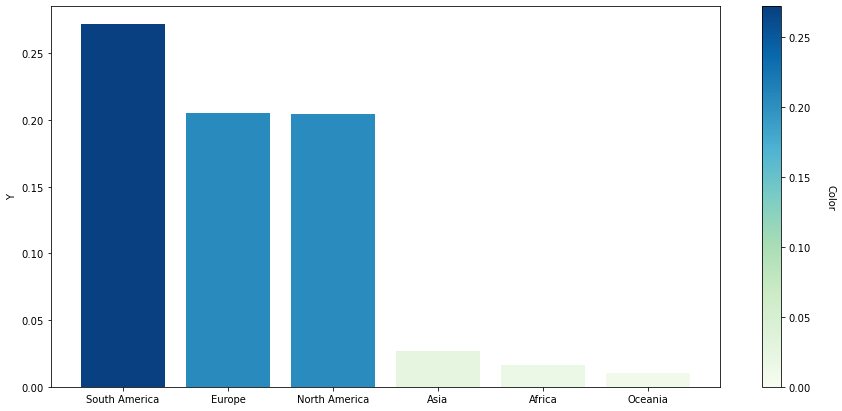

In [5]:
continent_deaths_percent = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT location, MAX(cast(population as int)) as population, SUM(cast(new_deaths as int)) as TotalDeathCount, SUM(cast(new_deaths as int))/population*100 as DeathsPercentage
FROM covid_data
WHERE continent = 'continent'
GROUP BY location
ORDER BY DeathsPercentage DESC
""")

data_hight_normalized = [x / max(continent_deaths_percent.DeathsPercentage) for x in continent_deaths_percent.DeathsPercentage]

fig, ax = plt.subplots(figsize=(15, 7))

my_cmap = plt.cm.get_cmap('GnBu')
colors = my_cmap(data_hight_normalized)

rects = ax.bar(continent_deaths_percent['location'], continent_deaths_percent.DeathsPercentage, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(continent_deaths_percent.DeathsPercentage)))

sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Color', rotation=270,labelpad=25)

plt.xticks(continent_deaths_percent['location'])    
plt.ylabel("Y")

#plt.title("% mortalité Covid-19 par continent (par rapport à la taille de la population)")

plt.show()

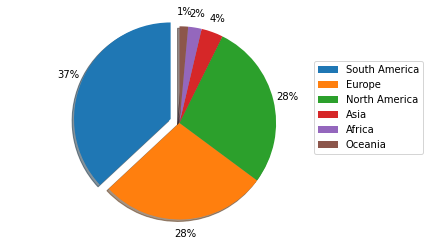

In [6]:
explode = (0.1, 0, 0, 0, 0,0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(continent_deaths_percent.DeathsPercentage*100, explode=explode, autopct='%1.0f%%', pctdistance=1.15, textprops={'fontsize': 10}, shadow=True, startangle=90)

plt.axis('equal')
plt.legend(continent_deaths_percent['location'],  bbox_to_anchor=(0.9, 0.8)) 


plt.show()

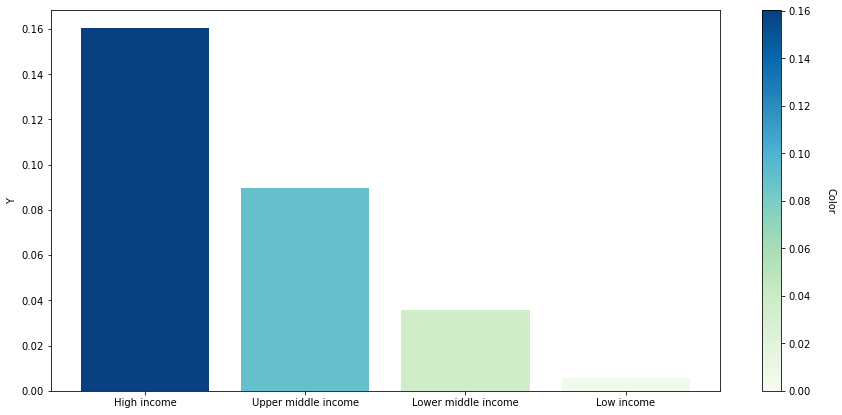

In [7]:
income_death_percent = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT location, MAX(cast(population as int)) as population, SUM(cast(new_deaths as int)) as TotalDeathCount, SUM(cast(new_deaths as int))/population*100 as DeathsPercentage
FROM covid_data
WHERE continent = 'income'
GROUP BY location
ORDER BY DeathsPercentage DESC
""")

data_hight_normalized = [x / max(income_death_percent.DeathsPercentage) for x in income_death_percent.DeathsPercentage]

fig, ax = plt.subplots(figsize=(15, 7))

my_cmap = plt.cm.get_cmap('GnBu')
colors = my_cmap(data_hight_normalized)

rects = ax.bar(income_death_percent['location'], income_death_percent.DeathsPercentage, color=colors)

sm = ScalarMappable(cmap=my_cmap, norm=plt.Normalize(0,max(income_death_percent.DeathsPercentage)))

sm.set_array([])

cbar = plt.colorbar(sm)
cbar.set_label('Color', rotation=270,labelpad=25)

plt.xticks(income_death_percent['location'])    
plt.ylabel("Y")

#plt.title("% mortalité Covid-19 par classe de revenu")

plt.show()

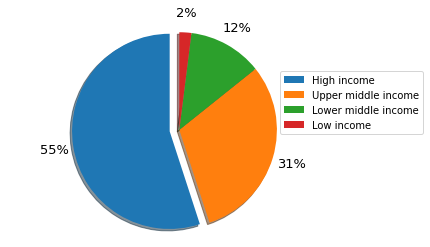

In [8]:
explode = (0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')

plt.pie(income_death_percent.DeathsPercentage*100, explode=explode, pctdistance=1.2, autopct='%1.0f%%', textprops={'fontsize': 13}, shadow=True, startangle=90)

plt.axis('equal')
plt.legend(income_death_percent['location'],  bbox_to_anchor=(0.8, 0.8)) 


plt.show()

In [9]:
#Analyse de l'excess de morts par continent
excess_mort = covid_data.copy()
excess_mort = analyse2[(analyse2['continent'] != 'continent')&(analyse2["continent"]!= 'income')&(analyse2["continent"] != 'World')&(analyse2["continent"] != 'international')]
excess_mort = analyse2[(analyse2['date'] > '2020-01-01') & (analyse2['date'] < '2021-12-31')] 
df_pays_pop_continent = excess_mort[['continent', 'location', 'population']]
df_pays_pop_continent = df_pays_pop_continent.drop_duplicates()

excess_mort = excess_mort[['continent', 'location','excess_mortality']]
excess_mort = excess_mort.groupby('location').sum()
excess_mort = excess_mort.reset_index()
excess_mort = pd.merge(left=df_pays_pop_continent,right=excess_mort, how='outer',on='location')
excess_mort_cont = excess_mort.groupby('continent').sum()
excess_mort_cont

,population,excess_mortality
continent,,
Africa,"1,371,693,397.00","2,694.49"
Asia,"4,652,616,087.00","10,832.40"
Europe,"750,800,113.00","39,618.09"
North America,"592,834,824.00","9,794.91"
Oceania,"43,198,762.00",-25.40
South America,"433,953,687.00","21,688.57"


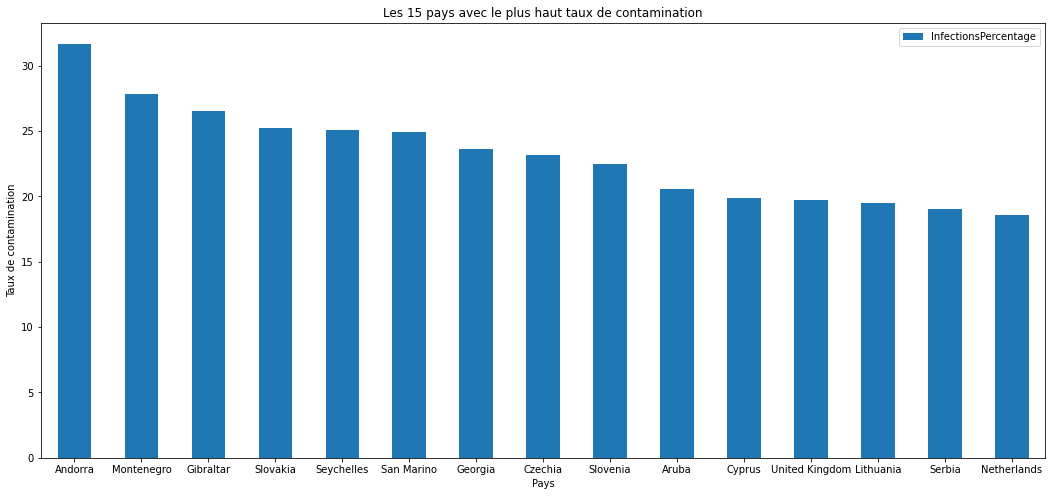

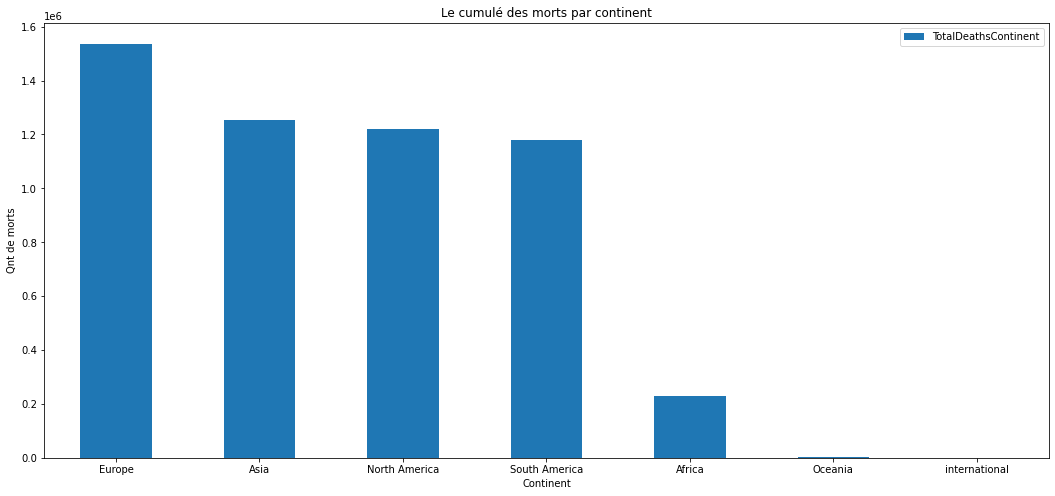

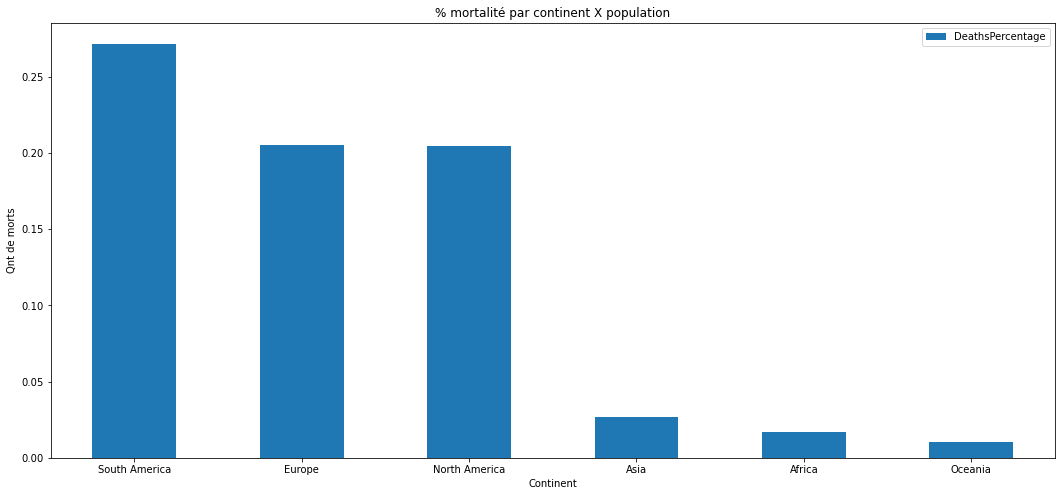

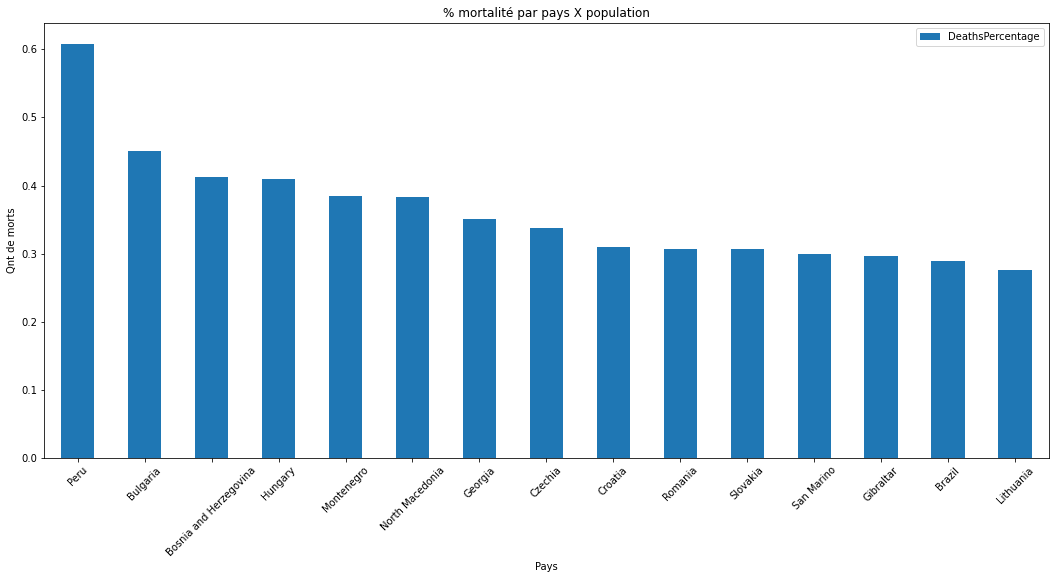

In [10]:
#On cherche à savoir les pays avec le plus haut taux de contamination par rapport à leur population

contamination_pays = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT Location, MAX(total_cases) as HighestInfectionCount, population, MAX((total_cases/population))*100 as InfectionsPercentage
FROM covid_data
GROUP BY Location, population
ORDER BY InfectionsPercentage DESC
LIMIT 15
""")

contamination_pays.plot.bar(x='location', y='InfectionsPercentage', rot=0, figsize=(18,8))
plt.title('Les 15 pays avec le plus haut taux de contamination')
plt.xlabel('Pays')
plt.ylabel('Taux de contamination')
plt.show()

#On cherche à savoir le cumulé des morts par continent 

morts_continent = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT continent, SUM(cast(new_deaths as int)) as TotalDeathsContinent
FROM covid_data
WHERE continent != 'continent' AND  continent != 'income' AND  continent != 'World'
GROUP BY continent
ORDER BY TotalDeathsContinent DESC

""")

morts_continent.plot.bar(x='continent', y='TotalDeathsContinent', rot=0, figsize=(18,8))
plt.title('Le cumulé des morts par continent')
plt.xlabel('Continent')
#plt.xticks(rotation = 45)
plt.ylabel('Qnt de morts')
plt.show()

#On cherche à savoir le pourcentage des morts par continent par rapport à la taile de la population 

morts_continent_population = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT DISTINCT location, MAX(cast(population as int)) as population, SUM(cast(new_deaths as int)) as TotalDeathCount, SUM(cast(new_deaths as int))/population*100 as DeathsPercentage
FROM covid_data
WHERE continent = 'continent'
GROUP BY location
ORDER BY DeathsPercentage DESC
""")

morts_continent_population.plot.bar(x='location', y='DeathsPercentage', rot=0, figsize=(18,8))
plt.title('% mortalité par continent X population')
plt.xlabel('Continent')
#plt.xticks(rotation = 45)
plt.ylabel('Qnt de morts')
plt.show()

#On cherche à savoir les pays avec le plus des morts par rapport à la taille de la population

pourcentage_morts_pays = pd.read_sql_query(con=bdd_engine,sql=f"""
SELECT Location, continent, MAX(cast(total_deaths as int)) as TotalDeathCount, population, MAX(cast(total_deaths as int))/population *100 as DeathsPercentage
FROM covid_data
WHERE continent != 'continent' AND  continent != 'income' AND  continent != 'World'
GROUP BY Location
ORDER BY DeathsPercentage DESC
LIMIT 15
""")

pourcentage_morts_pays.plot.bar(x='location', y='DeathsPercentage', rot=0, figsize=(18,8))
plt.title('% mortalité par pays X population')
plt.xlabel('Pays')
plt.xticks(rotation = 45)
plt.ylabel('Qnt de morts')
plt.show()


In [11]:
#liste de pays sans données de revenu moyen per capita == gdp_per_capita
income_filtre = covid_data.copy()
income_filtre = income_filtre[(income_filtre['continent'] != 'continent')&(income_filtre["continent"]!= 'income')&(income_filtre["continent"] != 'World')&(income_filtre["continent"] != 'international')]
income_filtre = income_filtre[['location', 'gdp_per_capita', 'population']]
income_filtre = income_filtre.drop_duplicates()
filtre = income_filtre['gdp_per_capita'].isnull()
income_filtre = income_filtre[filtre]
income_filtre = income_filtre.reset_index()

In [12]:
#Création de notre df mensualisé pour utilisation dans les graphiques après clusterings
covid_data_month = covid_data.copy()
covid_data_month = covid_data_month[(covid_data_month['date'] > '2020-01-01') & (covid_data_month['date'] < '2021-12-31')]
covid_data_month['date'] = pd.to_datetime(covid_data_month['date'])
covid_data_month['month_year'] = covid_data_month['date'].apply(lambda x: x.strftime('%B-%Y')) 
covid_data_month = covid_data_month[['continent','location', 'month_year', 'population','total_deaths', 'total_cases', 'stringency_index', 'median_age', 'aged_65_older', 'aged_70_older', 'people_fully_vaccinated', 'gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index', 'excess_mortality_cumulative_absolute', 'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', 'male_smokers']]

covid_data_month = covid_data_month.groupby([
                 pd.Grouper('month_year'),
                 pd.Grouper('location')]).max().reset_index()

covid_data_month["month_year"] = pd.to_datetime(covid_data_month["month_year"])
covid_data_month['total_deaths_pop'] = covid_data_month['total_deaths']/covid_data_month['population']*100
covid_data_month['total_cases_pop'] = covid_data_month['total_cases']/covid_data_month['population']*100


covid_data_month = covid_data_month.fillna(0)
covid_data_month = covid_data_month.reset_index()
covid_data_month.drop(['index'],  axis=1, inplace=True)
covid_data_month = covid_data_month.sort_values('month_year', ascending=True)
covid_data_month

,month_year,location,continent,population,total_deaths,total_cases,stringency_index,median_age,aged_65_older,aged_70_older,...,extreme_poverty,life_expectancy,human_development_index,excess_mortality_cumulative_absolute,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,total_deaths_pop,total_cases_pop
1690,2020-01-01,Portugal,Europe,"10,167,923.00",0.00,0.00,0.00,46.20,21.50,14.92,...,0.50,82.05,0.86,0.00,127.84,9.85,16.30,30.00,0.00,0.00
1680,2020-01-01,Latvia,Europe,"1,866,934.00",0.00,0.00,0.00,43.90,19.75,14.14,...,0.70,75.29,0.87,0.00,350.06,4.91,25.60,51.00,0.00,0.00
1679,2020-01-01,Japan,Asia,"126,050,796.00",0.00,15.00,2.78,48.20,27.05,18.49,...,0.00,84.63,0.92,"-7,817.80",79.37,5.72,11.20,33.70,0.00,0.00
1678,2020-01-01,Italy,Europe,"60,367,471.00",0.00,2.00,19.44,47.90,23.02,16.24,...,2.00,83.51,0.89,0.00,113.15,4.78,19.80,27.80,0.00,0.00
1677,2020-01-01,India,Asia,"1,393,409,033.00",0.00,1.00,10.19,28.20,5.99,3.41,...,21.20,69.66,0.65,0.00,282.28,10.39,1.90,20.60,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1199,2021-12-01,Gibraltar,Europe,"33,691.00",100.00,"8,533.00",0.00,0.00,0.00,0.00,...,0.00,79.93,0.00,0.00,0.00,0.00,0.00,0.00,0.30,25.33
1200,2021-12-01,Greece,Europe,"10,370,747.00","20,708.00","1,170,293.00",80.09,45.30,20.40,14.52,...,1.50,82.24,0.89,0.00,175.69,4.55,35.30,52.00,0.20,11.28
1201,2021-12-01,Greenland,North America,"56,868.00",1.00,"2,610.00",34.26,0.00,0.00,0.00,...,0.00,71.70,0.00,0.00,199.94,2.16,0.00,0.00,0.00,4.59
1203,2021-12-01,Guatemala,North America,"18,249,868.00","16,106.00","627,562.00",45.37,22.90,4.69,3.02,...,8.70,74.30,0.66,0.00,155.90,10.18,0.00,0.00,0.09,3.44


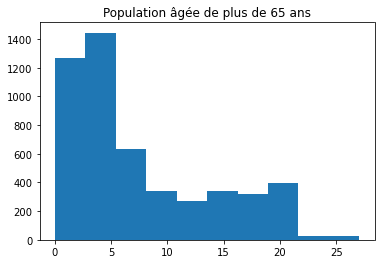

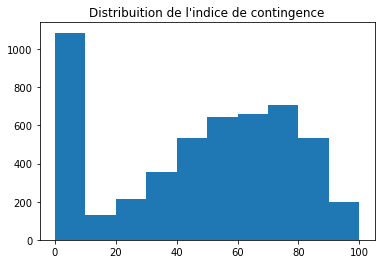

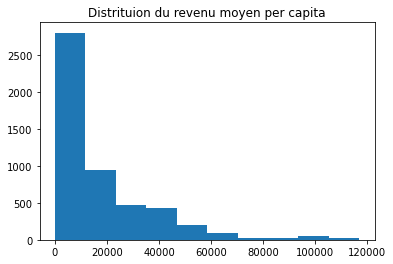

In [13]:
#affichage de la distribuition de quelques variables 
fig, ax = plt.subplots()
ax.hist(covid_data_month.aged_65_older)
plt.title("Population âgée de plus de 65 ans")

plt.show()

fig, ax = plt.subplots()
ax.hist(covid_data_month.stringency_index)
plt.title("Distribuition de l'indice de contingence")

plt.show()

fig, ax = plt.subplots()
ax.hist(covid_data_month.gdp_per_capita)
plt.title("Distrituion du revenu moyen per capita")

plt.show()

In [14]:
#Premier clustering pour faire l'analyse des variables socio-économiques des pays
class Clustering_income :
    def __init__(self, nb_cluster):
        random_state=0
        #Transformation en array Numpy
        #Indexation selon les pays par la fonction .set_index()
        df_clustering = covid_data.copy()

        #Par simplification (gain en temps de calcul), le clustering sera fait sur les données de 01/01/2020 à 31/12/2021
        df_clustering = df_clustering[(df_clustering['date'] > '2020-01-01') & (df_clustering['date'] < '2021-12-31')]   
        #Suppression des lignes 
        df_clustering = df_clustering[(df_clustering['continent'] != 'continent')&(df_clustering["continent"]!= 'income')&(df_clustering["continent"] != 'World')&(df_clustering["continent"] != 'international')]
        df_clustering = df_clustering.dropna(subset=['gdp_per_capita'])
        #Remplissage avec des 0 pour les valeurs manquants
        df_clustering = df_clustering.fillna(0)
        df_clustering = df_clustering [['location','date', 'gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index']] 
        df_clustering = df_clustering.groupby('location').mean()

        
        #Préparation des données pour le clustering K-Means
        #Ici le clustering sera établi sur les valeurs des variables "économiques" et sociales    
        X = df_clustering.loc[:, ['gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index']].values
        Y = df_clustering.index
        
        #Centrage / réduction des données (nécessaire pour éviter les décalages d'échelle)
        std_scale = preprocessing.StandardScaler().fit(X)
        X_scaled = std_scale.transform(X)
                
        cls = cluster.KMeans(n_clusters=nb_cluster, random_state=0)
        cls.fit(X_scaled)
        centroids = cls.cluster_centers_
        df0= pd.DataFrame(centroids, columns=['gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index'], index=["Cluster" + str(i+1) for i in range(nb_cluster)])
    
        #Index trié des clusters
        idk = np.argsort(cls.labels_)
    
        #Affichage des observations selon leurs clusters
        df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
        df_cls = df_cls.rename(columns={'index':'cluster'})

        #Jointure avec le dataframe initial selon les pays et condition 'inner' 
        df_cls = pd.merge(df_clustering, df_cls, on='location')

        #Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
        Z = linkage(X_scaled, method = 'ward', metric='euclidean')

        #Calcul des composantes principales
        n_comp = 4
        pca = decomposition.PCA(n_components=n_comp)
        pca.fit(X_scaled)

        #Calcul des composantes principales
        X_projected = pca.transform(X_scaled)
        df_facto = pd.DataFrame(X_projected, index=df_cls.index, columns=['gdp_per_capita', 'extreme_poverty', 'life_expectancy', 'human_development_index'])
        df_facto_groupe =  pd.merge(df_facto, df_cls,left_index=True, right_index=True) 
        df_facto_groupe = df_facto_groupe[['location','gdp_per_capita_x', 'extreme_poverty_x', 'life_expectancy_x', 'human_development_index_x', 'cluster']] 
        df_facto_groupe.rename(columns={'gdp_per_capita_x': 'gdp_per_capita', 'extreme_poverty_x': 'extreme_poverty', 'life_expectancy_x': 'life_expectancy','human_development_index_x': 'human_development_index', },  inplace=True)
        df_facto_groupe = df_facto_groupe.sort_values('gdp_per_capita', ascending=True)
        df_facto_groupe['rang'] = df_facto_groupe['gdp_per_capita'].rank(ascending=True)
        df_facto_groupe['cluster'] = df_facto_groupe['cluster'].replace({3 : 0, 2 : 1, 0: 2, 4 :3, 1: 4})
        
        #Affichage des pays les plus contributeurs avec restriction 
        di = np.sum(X_scaled**2,axis=1)
        ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'location':df_clustering.index,'cluster': df_cls['cluster'], 'gdp_per_capita':df_cls['gdp_per_capita'],
                                      'human_development_index': df_cls['human_development_index'], 'extreme_poverty': df_cls['extreme_poverty'], 'life_expectancy': df_cls['life_expectancy']}).sort_values(by='c_inertie',
                                                                                                       ascending=False)
        #Normalisation des données
        pays_info_norm = preprocessing.scale(X)
        km = cluster.KMeans(n_clusters = nb_cluster, random_state=0).fit(pays_info_norm)

        #On determine les pays qui sont les plus proches des centroides des clusters
        i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)
        pays_representatifs_cluster = df_cls.iloc[i_pays_plus_proches].sort_values('gdp_per_capita', ascending=False)
        df_cls['cluster'] = df_cls['cluster'].replace({3 : 0, 2 : 1, 0: 2, 4 :3, 1: 4})
        
        self.nb_cluster =nb_cluster
        self.Z = Z
        self.df_cls= df_cls
        self.X_projected = X_projected
        self.n_comp = n_comp
        self.pca = pca
        self.cls = cls
        self.centroids = centroids
        self.df0 = df0
        self.idk = idk
        self.df_facto = df_facto
        self.df_facto_groupe = df_facto_groupe
        self.di = di
        self.ctr_indiv_inertie = ctr_indiv_inertie
        self.pays_info_norm = pays_info_norm
        self.km = km
        self.i_pays_plus_proches = i_pays_plus_proches
        self.pays_representatifs_cluster = pays_representatifs_cluster
        self.X = X
            
    def pays_cluster (self):   
        
        table =  self.pays_representatifs_cluster
        table['cluster'] = table['cluster'].replace({3 : 0, 2 : 1, 0: 2, 4 :3, 1: 4})
        
        return table
    
    def rang_cluster (self):   
        
        return self.df_facto_groupe
    
    def projection (self):    
        
        display_factorial_planes(self.X_projected, self.n_comp, self.pca, [(0,1)], illustrative_var=self.df_cls['cluster'])
        
    def revenus_idh (self):
        #self.pays_representatifs_cluster.plot.bar(x='location', y='gdp_per_capita', rot=0, figsize=(18,8))
        #plt.title('Distribution des revenus per capita pour le pays le plus répresentatif de chaque cluster')
        #plt.xlabel('Pays')
        #plt.xticks(rotation = 45)
        #plt.ylabel('Revenu moyen per capita')
        #plt.legend()

        df =  self.pays_representatifs_cluster.copy()

        fig = plt.figure() # Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        width = 0.4

        df.gdp_per_capita.plot(kind='bar', ax=ax, width=width, position=1, figsize=(18,8))
        df.human_development_index.plot(kind='bar', color='darkorange', ax=ax2, width=width, position=0)

        ax.set_ylabel('gdp_per_capita')
        ax2.set_ylabel('human_development_index')
        ax.set_xticklabels((df['location']), rotation = 45)
        plt.title("Distribution des revenus per capita et de l'IDH pour les pays le plus répresentatifs de chaque cluster")
        plt.legend()
 
    def l_pays (self, x): 
        
        l_pays = [self.df_cls[self.df_cls['cluster'] == i]['location'].tolist() for i in range(self.nb_cluster)]

        return l_pays[x]


    def df_pays_cluster(self): 
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        
        return df_pays_cluster    
    
    def distribuition_pays (self): 
        
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        df_pays_cluster = df_pays_cluster.groupby(pd.Grouper(key='cluster')).count().reset_index()
        df_pays_cluster = df_pays_cluster.sort_values('cluster', ascending=True)

        plots = df_pays_cluster.plot.bar(x='cluster',legend=None, y='location', color=['C0', 'C1', 'C2', 'C3', 'C4'], rot=0, figsize=(8,6))
        for bar in plots.patches:   
            plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, 5), 
                   textcoords='offset points') 
            
        plt.title('Analyse de la distrubution des pays pour le clustering des variables socio-économiques')
        plt.xlabel('cluster')
        plt.ylabel('Qnt de pays') 
        plt.show()
    
    
    
    def poverty_life_expectancy (self):
        df =  self.pays_representatifs_cluster.copy()

        fig = plt.figure() # Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        width = 0.4

        df.extreme_poverty.plot(kind='bar', ax=ax, width=width, position=1, figsize=(18,8))
        df.life_expectancy.plot(kind='bar', color='darkorange', ax=ax, width=width, position=0)
        plt.title('Analyse de la pauvreté et de la espérance de vie pour les pays le plus répresentatifs de chaque cluster')
        ax.set_ylabel('extreme_poverty')
        ax2.set_ylabel('life_expectancy')
        ax.set_xticklabels((df['location']), rotation = 45)
        plt.legend()

In [15]:
clustering_income = Clustering_income(5)

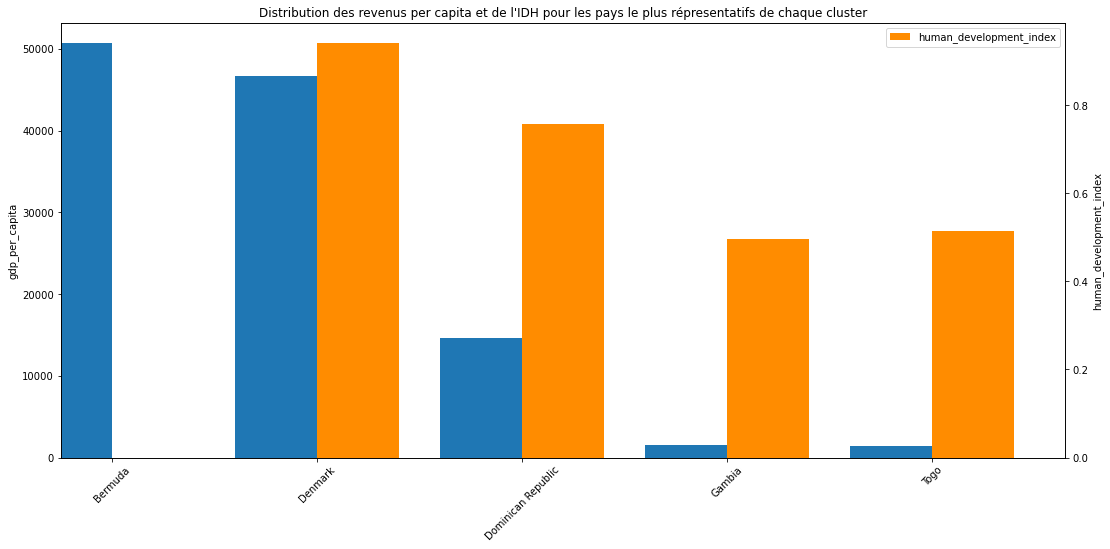

In [16]:
clustering_income.revenus_idh()

In [17]:
#df avec le ranking des pays en ordre du plus riche au plus pauvre
rang_cluster_income = clustering_income.rang_cluster()

#affichage des pays centroides de notre clustering_income
clustering_income.pays_cluster()

,location,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,cluster
19,Bermuda,"50,669.32",0.00,82.59,0.00,0
47,Denmark,"46,682.52",0.20,80.90,0.94,1
50,Dominican Republic,"14,600.86",1.60,74.08,0.76,2
63,Gambia,"1,561.77",10.10,62.05,0.50,3
174,Togo,"1,429.81",49.20,61.04,0.51,4


In [18]:
rang_cluster_income

,location,gdp_per_capita,extreme_poverty,life_expectancy,human_development_index,cluster,rang
141,Qatar,-3.43,2.34,-1.98,1.85,1,1.00
101,Luxembourg,-3.16,1.42,-1.57,1.31,1,2.00
156,Singapore,-3.09,1.07,-1.42,1.04,1,3.00
82,Ireland,-2.61,0.49,-1.00,0.78,1,4.00
129,Norway,-2.56,0.41,-0.94,0.72,1,5.00
...,...,...,...,...,...,...,...
97,Lesotho,3.22,-0.45,-1.55,0.77,4,190.00
71,Guinea-Bissau,3.31,-0.44,-1.98,0.29,4,191.00
28,Burundi,3.35,-0.38,-2.27,-0.11,4,192.00
46,Democratic Republic of Congo,3.44,-0.62,-2.52,0.06,4,193.00


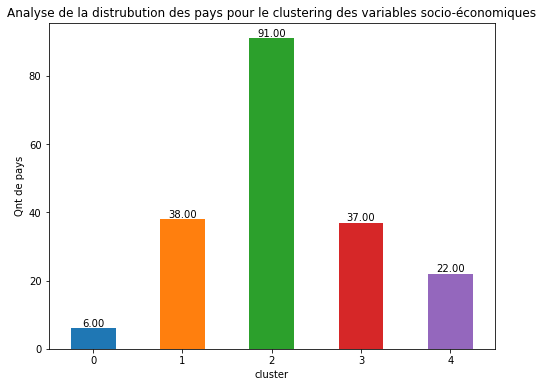

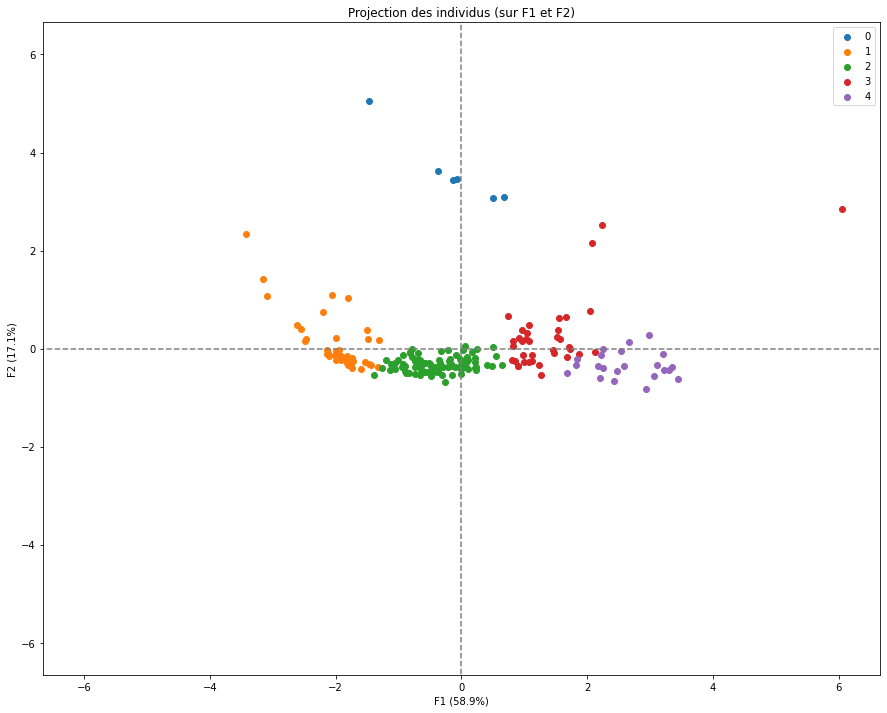

In [19]:
#création des listes de pays par cluster 
l_pays_cluster_income_0 = clustering_income.l_pays(0)
l_pays_cluster_income_1 = clustering_income.l_pays(1)
l_pays_cluster_income_2 = clustering_income.l_pays(2)
l_pays_cluster_income_3 = clustering_income.l_pays(3)
l_pays_cluster_income_4 = clustering_income.l_pays(4)

#affichage de la distribuition des pays par cluster
clustering_income.distribuition_pays()

#affichage de la projection de la distribuition des pays sur le 1er plan factoriel
clustering_income.projection()

In [20]:
#Deuxième clustering pour faire l'analyse des variables liées au Covid pour chaque pays
class Clustering_covid :
    def __init__(self, nb_cluster):
        random_state=42
        #Transformation en array Numpy
        #Indexation selon les pays par la fonction .set_index()
        df_clustering = covid_data.copy()
        df_clustering.set_index('location', inplace=True)

        #Par simplification (gain en temps de calcul), le clustering sera fait sur les données le plus à jour 
        df_clustering = df_clustering[df_clustering['date'] == date] 
        #Suppression des lignes
        df_clustering = df_clustering[(df_clustering['continent'] != 'continent')&(df_clustering["continent"]!= 'income')&(df_clustering["continent"] != 'World')&(df_clustering["continent"] != 'international')]
        #Remplissage des valeurs manquants par zéro
        df_clustering = df_clustering.fillna(0)
        
        df_clustering['total_deaths_pop'] = df_clustering['total_deaths']/df_clustering['population']*100
        df_clustering['total_cases_pop'] = df_clustering['total_cases']/df_clustering['population']*100
       

        
        #Préparation des données pour le clustering K-Means
        #Ici le clustering sera établi sur les valeurs des variables "covid" 
        X = df_clustering.loc[:, ['total_deaths', 'total_cases']].values
        Y = df_clustering.index
        
        #Centrage / réduction des données (nécessaire pour éviter les décalages d'échelle)
        std_scale = preprocessing.StandardScaler().fit(X)
        X_scaled = std_scale.transform(X)
                
        cls = cluster.KMeans(n_clusters=nb_cluster, random_state=0)
        cls.fit(X_scaled)
        centroids = cls.cluster_centers_
        df0= pd.DataFrame(centroids, columns=['total_deaths_pop', 'total_cases_pop'], index=["Cluster" + str(i+1) for i in range(nb_cluster)])
    
        #Index trié des clusters
        idk = np.argsort(cls.labels_)
    
        #Affichage des observations selon leurs clusters
        df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
        df_cls = df_cls.rename(columns={'index':'cluster'})

        #Jointure avec le dataframe initial selon les pays et condition 'inner' 
        df_cls = pd.merge(df_clustering, df_cls, on='location')

        #Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
        Z = linkage(X_scaled, method = 'ward', metric='euclidean')

        #Calcul des composantes principales
        n_comp = 2
        pca = decomposition.PCA(n_components=n_comp)
        pca.fit(X_scaled)

        #Calcul des composantes principales
        X_projected = pca.transform(X_scaled)
        df_facto = pd.DataFrame(X_projected, index=df_cls.index, columns=['total_cases_pop', 'total_deaths_pop'])
        df_facto_groupe =  pd.merge(df_facto, df_cls,left_index=True, right_index=True) 
        df_facto_groupe = df_facto_groupe[['location', 'iso_code', 'continent','total_cases_pop_x', 'total_deaths_pop_x', 'cluster']] 
        df_facto_groupe.rename(columns={'total_cases_pop_x': 'total_cases_pop', 'total_deaths_pop_x': 'total_deaths_pop',},  inplace=True)
        
        
        #Affichage des pays les plus contributeurs avec restriction selon le cluster 0 
        di = np.sum(X_scaled**2,axis=1)
        ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'location':df_clustering.index, 
                                      'iso_code': df_cls['iso_code'],'continent': df_cls['continent'], 'cluster': df_cls['cluster'], 'total_cases_pop':df_cls['total_cases_pop'],
                                      'total_deaths_pop': df_cls['total_deaths_pop']}).sort_values(by='c_inertie', ascending=False)
        #Normalisation des données
        pays_info_norm = preprocessing.scale(X)
        km = cluster.KMeans(n_clusters = nb_cluster).fit(pays_info_norm)

        #On determine les pays qui sont les plus proches des centroides des clusters
        i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)
        pays_representatifs_cluster = df_cls.iloc[i_pays_plus_proches].sort_values('total_deaths_pop', ascending=False)
        pays_representatifs_cluster = pays_representatifs_cluster[['location','cluster','total_deaths','total_deaths_pop','total_cases','total_cases_pop']]
    
        self.nb_cluster =nb_cluster
        self.Z = Z
        self.df_cls= df_cls
        self.X_projected = X_projected
        self.n_comp = n_comp
        self.pca = pca
        self.cls = cls
        self.centroids = centroids
        self.df0 = df0
        self.idk = idk
        self.df_facto = df_facto
        self.df_facto_groupe = df_facto_groupe
        self.di = di
        self.ctr_indiv_inertie = ctr_indiv_inertie
        self.pays_info_norm = pays_info_norm
        self.km = km
        self.i_pays_plus_proches = i_pays_plus_proches
        self.pays_representatifs_cluster = pays_representatifs_cluster
        self.X = X
        self.date = date

    def pays_cluster (self):   
        
        return self.pays_representatifs_cluster
        
    def projection (self):    
        
        display_factorial_planes(self.X_projected, self.n_comp, self.pca, [(0,1)], illustrative_var=self.df_cls['cluster'])
        
    def l_pays (self, x): 
        
        l_pays = [self.df_cls[self.df_cls['cluster'] == i]['location'].tolist() for i in range(self.nb_cluster)]

        return l_pays[x]
    
    def df_pays_cluster(self): 
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        
        return df_pays_cluster    
    
    def distribuition_pays (self): 
        
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        df_pays_cluster = df_pays_cluster.groupby(pd.Grouper(key='cluster')).count().reset_index()
        df_pays_cluster = df_pays_cluster.sort_values('cluster', ascending=True)

        plots = df_pays_cluster.plot.bar(x='cluster',legend=None, y='location', color=['C0', 'C1', 'C2', 'C3', 'C4'], rot=0, figsize=(8,6))
        for bar in plots.patches:   
            plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, 5), 
                   textcoords='offset points') 
            
        plt.title('Analyse de la distrubution des pays pour le clustering des variables type "Covid-19"')
        plt.xlabel('cluster')
        plt.ylabel('Qnt de pays') 
        plt.show()
    
        
    def cases_deaths (self):

        df =  self.pays_representatifs_cluster.copy()
        fig = plt.figure() # Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        width = 0.4

        df.total_cases.plot(kind='bar', ax=ax, width=width, position=1, figsize=(18,8))
        df.total_deaths.plot(kind='bar', color='darkorange', ax=ax, width=width, position=0)

        ax.set_ylabel('total_cases_pop')
        ax2.set_ylabel('total_deaths_pop')
        ax.set_xticklabels((df['location']), rotation = 45)
        plt.title("Analyse de l'incidence et de la mortalité pour les pays le plus répresentatifs de chaque cluster")
        plt.legend()

In [21]:
clustering_covid = Clustering_covid(5)

In [22]:
#création des listes de pays par cluster
l_pays_cluster_covid_0 = clustering_covid.l_pays(0)
l_pays_cluster_covid_1 = clustering_covid.l_pays(1)
l_pays_cluster_covid_2 = clustering_covid.l_pays(2)
l_pays_cluster_covid_3 = clustering_covid.l_pays(3)
l_pays_cluster_covid_4 = clustering_covid.l_pays(4)
l_pays_cluster_covid = clustering_covid.pays_cluster()
l_pays_cluster_covid = l_pays_cluster_covid['location'].tolist()
#affichage des pays centroides de notre clustering_covid
clustering_covid.pays_cluster()

,location,cluster,total_deaths,total_deaths_pop,total_cases,total_cases_pop
204,United States,2,"825,549.00",0.25,"54,742,382.00",16.44
126,Mexico,4,"299,428.00",0.23,"3,979,723.00",3.06
75,Germany,3,"112,111.00",0.13,"7,193,186.00",8.57
112,Libya,0,"5,710.00",0.08,"388,734.00",5.59
90,India,1,"481,486.00",0.03,"34,861,579.00",2.50


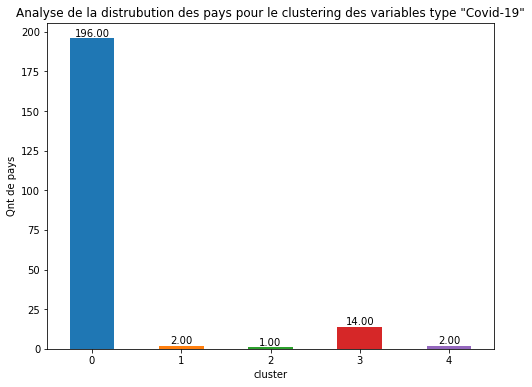

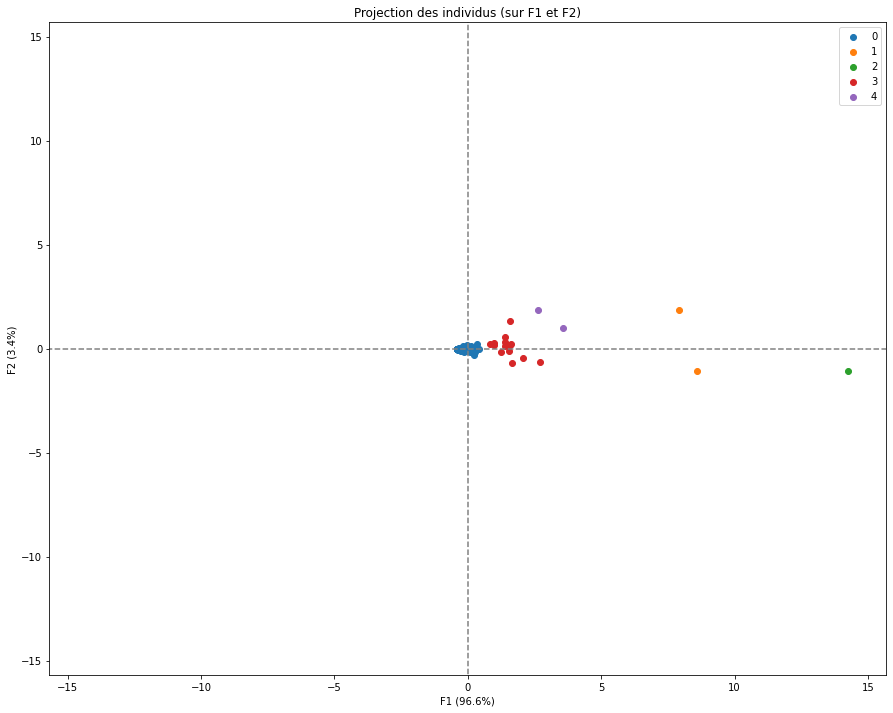

In [23]:
#affichage de la distribuition des pays par cluster
clustering_covid.distribuition_pays()

#affichage de la projection de la distribuition des pays sur le 1er plan factoriel
clustering_covid.projection()

In [24]:
#Deuxième clustering pour faire l'analyse des variables liées au Covid pour chaque pays
class Clustering_mesure :
    def __init__(self, nb_cluster):
        random_state=0
        #Transformation en array Numpy
        #Indexation selon les pays par la fonction .set_index()
        df_clustering = covid_data.copy()

        #Par simplification (gain en temps de calcul), le clustering sera fait sur les données de 01/01/2020 à 31/12/2021
        
        df_clustering = df_clustering[(df_clustering['date'] > '2020-01-01') & (df_clustering['date'] < '2021-12-31')]
        df_clustering = df_clustering[['iso_code', 'continent','location', 'stringency_index']]
        #Suppression des lignes
        df_clustering = df_clustering[(df_clustering['continent'] != 'continent')&(df_clustering["continent"]!= 'income')&(df_clustering["continent"] != 'World')&(df_clustering["continent"] != 'international')]
        df_clustering = df_clustering.dropna(subset=['stringency_index'])
        df_clustering = df_clustering.fillna(0)
        df_clustering = df_clustering.groupby([pd.Grouper('location')]).mean().reset_index()
        df_clustering.set_index('location', inplace=True)

        
        #Préparation des données pour le clustering K-Means
        #Ici le clustering sera établi sur les valeurs des variables "covid" 
        X = df_clustering.loc[:, ['stringency_index']].values
        Y = df_clustering.index
        
        #Centrage / réduction des données (nécessaire pour éviter les décalages d'échelle)
        std_scale = preprocessing.StandardScaler().fit(X)
        X_scaled = std_scale.transform(X)
                
        cls = cluster.KMeans(n_clusters=nb_cluster, random_state=0)
        cls.fit(X_scaled)
        centroids = cls.cluster_centers_
        df0= pd.DataFrame(centroids, columns=['stringency_index'], index=["Cluster" + str(i+1) for i in range(nb_cluster)])
    
        #Index trié des clusters
        idk = np.argsort(cls.labels_)
    
        #Affichage des observations selon leurs clusters
        df_cls = pd.DataFrame(df_clustering.index[idk], cls.labels_[idk]).reset_index()
        df_cls = df_cls.rename(columns={'index':'cluster'})

        #Jointure avec le dataframe initial selon les pays et condition 'inner' 
        df_cls = pd.merge(df_clustering, df_cls, on='location')

        #Clustering hiérarchique: création d'une Matrice des liens selon la Méthode de Ward
        Z = linkage(X_scaled, method = 'ward', metric='euclidean')

        #Calcul des composantes principales
        n_comp = 1
        pca = decomposition.PCA(n_components=n_comp)
        pca.fit(X_scaled)

        #Calcul des composantes principales
        X_projected = pca.transform(X_scaled)
        df_facto = pd.DataFrame(X_projected, index=df_cls.index, columns=['stringency_index'])
        df_facto_groupe =  pd.merge(df_facto, df_cls,left_index=True, right_index=True) 
        df_facto_groupe = df_facto_groupe[['location', 'stringency_index_x', 'cluster']] 
        df_facto_groupe.rename(columns={'stringency_index_x': 'stringency_index'},  inplace=True)

        #Affichage des pays les plus contributeurs avec restriction selon le cluster 
        di = np.sum(X_scaled**2,axis=1)
        ctr_indiv_inertie = pd.DataFrame({'c_inertie':di, 'location':df_clustering.index, 'cluster': df_cls['cluster'], 'stringency_index':df_cls['stringency_index']}).sort_values(by='c_inertie', ascending=False)
        #Normalisation des données
        pays_info_norm = preprocessing.scale(X)
        km = cluster.KMeans(n_clusters = nb_cluster).fit(pays_info_norm)

        #On determine les pays qui sont les plus proches des centroides des clusters
        i_pays_plus_proches, _ = pairwise_distances_argmin_min(km.cluster_centers_, pays_info_norm)
        pays_representatifs_cluster = df_cls.iloc[i_pays_plus_proches].sort_values('stringency_index', ascending=False)
        
        self.nb_cluster =nb_cluster
        self.Z = Z
        self.df_cls= df_cls
        self.X_projected = X_projected
        self.n_comp = n_comp
        self.pca = pca
        self.cls = cls
        self.centroids = centroids
        self.df0 = df0
        self.idk = idk
        self.df_facto = df_facto
        self.df_facto_groupe = df_facto_groupe
        self.di = di
        self.ctr_indiv_inertie = ctr_indiv_inertie
        self.pays_info_norm = pays_info_norm
        self.km = km
        self.i_pays_plus_proches = i_pays_plus_proches
        self.pays_representatifs_cluster = pays_representatifs_cluster
        self.X = X
            
    def pays_cluster (self):   
        
        return self.pays_representatifs_cluster
    
    def projection (self):    
        
        return display_factorial_planes(self.X_projected, self.n_comp, self.pca, [(0,1)], illustrative_var=self.df_cls['cluster'])
        
    def l_pays (self, x): 
        
        l_pays = [self.df_cls[self.df_cls['cluster'] == i]['location'].tolist() for i in range(self.nb_cluster)]

        return l_pays[x]
        
        
    def df_pays_cluster(self): 
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        
        return df_pays_cluster    
    
    def distribuition_pays (self): 
        
        df_pays_cluster = self.df_cls.copy()
        df_pays_cluster = df_pays_cluster[['location','cluster']]

        df_pays_cluster = df_pays_cluster.groupby(pd.Grouper(key='cluster')).count().reset_index()
        df_pays_cluster = df_pays_cluster.sort_values('cluster', ascending=True)

        plots = df_pays_cluster.plot.bar(x='cluster',legend=None, y='location', color=['C0', 'C1', 'C2', 'C3', 'C4'], rot=0, figsize=(15,8))
        for bar in plots.patches:   
            plots.annotate(format(bar.get_height(), '.2f'),  
                   (bar.get_x() + bar.get_width() / 2,  
                    bar.get_height()), ha='center', va='center', 
                   size=10, xytext=(0, 5), 
                   textcoords='offset points') 
            
        plt.title('Analyse de la distrubution des pays pour le clustering "contingence de crise"')
        plt.xlabel('cluster')
        plt.ylabel('Qnt de pays') 
        plt.show()
        
    def stringency_index (self):

        df =  self.pays_representatifs_cluster.copy()
        fig = plt.figure() # Create matplotlib figure

        ax = fig.add_subplot(111) # Create matplotlib axes
        ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.

        width = 0.4

        df.total_cases.plot(kind='bar', ax=ax, width=width, position=1, figsize=(18,8))
       
        ax.set_ylabel('stringency_index')
        ax.set_xticklabels((df['location']), rotation = 45)
        plt.title("Analyse des politiques pour frener la pandemie")
        plt.legend()

In [25]:
clustering_mesure = Clustering_mesure(5)

In [26]:
#Création des listes de pays par cluster
l_pays_cluster_mesure_0 = clustering_mesure.l_pays(0)
l_pays_cluster_mesure_1 = clustering_mesure.l_pays(1)
l_pays_cluster_mesure_2 = clustering_mesure.l_pays(2)
l_pays_cluster_mesure_3 = clustering_mesure.l_pays(3)
l_pays_cluster_mesure_4 = clustering_mesure.l_pays(4)

#Création de notre df pays x cluster pour le clustering_mesure (contingence) 
df_pays_cluster_mesure = clustering_mesure.df_pays_cluster()

#Afficchage des pays centroides de notre clustering_mesure (contingence)
clustering_mesure.pays_cluster()

,location,stringency_index,cluster
41,Cuba,70.67,4
152,Sri Lanka,61.84,0
149,South Korea,51.85,3
17,Benin,42.73,1
120,Niger,27.31,2


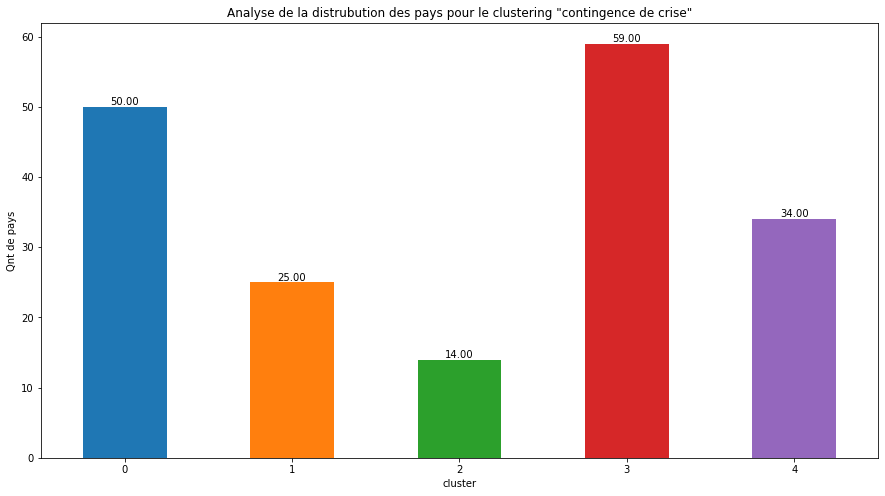

In [27]:
clustering_mesure.distribuition_pays()

# ANALYSE DES MORTS POUR LES CENTROIDES DU CLUSTER_COVID

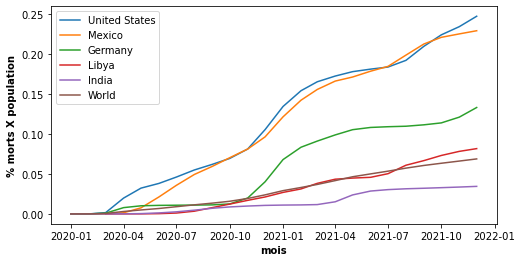

In [28]:
cluster_covid_pays_list = clustering_covid.pays_cluster()
cluster_covid_pays_list = cluster_covid_pays_list['location'].tolist()

cluster_covid_pays_list_world = cluster_covid_pays_list + ['World']
cluster_covid_pays_list_world

#Affichage %morts vs taille population par pays centroides du clustering - Covid
fig =plt.figure(figsize=(8,4))
for x in cluster_covid_pays_list_world: 
    data = covid_data_month.copy()
    data = data[data['location'] == x]
    plt.plot(data['month_year'], (data['total_deaths_pop']), label=x)
    plt.xlabel("mois", fontsize=10, fontweight='bold')
    plt.ylabel("% morts X population", fontsize=10, fontweight='bold')
    plt.legend()    


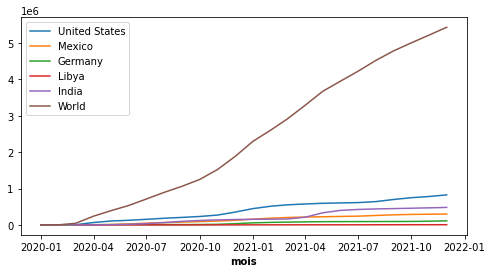

In [29]:
cluster_covid_pays_list = clustering_covid.pays_cluster()
cluster_covid_pays_list = cluster_covid_pays_list['location'].tolist()

cluster_covid_pays_list_world = cluster_covid_pays_list + ['World']
cluster_covid_pays_list_world

#Affichage %morts vs taille population par pays centroides du clustering - Covid
fig =plt.figure(figsize=(8,4))
for x in cluster_covid_pays_list_world: 
    data = covid_data_month.copy()
    data = data[data['location'] == x]
    plt.plot(data['month_year'], (data['total_deaths']), label=x)
    plt.xlabel("mois", fontsize=10, fontweight='bold')
    plt.legend() 

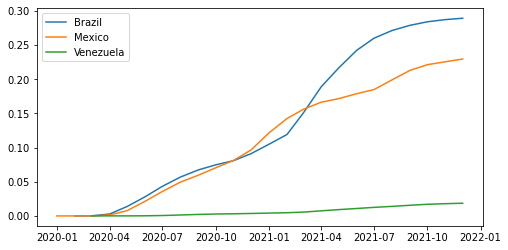

In [30]:
l_pays_am_sud = ['Brazil'] + ['Mexico'] +['Venezuela']
l_pays_am_sud_contingence = ['Brazil : 65'] + ['Mexico : 58'] +['Venezuela : 85']


#Affichage %morts vs taille population par pays centroides du clustering - Covid
fig =plt.figure(figsize=(8,4))
for x in l_pays_am_sud: 
    data = covid_data_month.copy()
    data = data[data['location'] == x]
    plt.plot(data['month_year'], (data['total_deaths_pop']), label=x)
    plt.legend() 

In [31]:
l_pays_am_sud_contingence = ['Brazil : 65'] + ['Mexico : 58'] +['Venezuela : 85']

# ANALYSE DE L'EXCES DE MORTS

In [32]:
covid_data_month_excess = covid_data_month[['month_year', 'continent','location', 'population','excess_mortality_cumulative_absolute', 'total_deaths' ]]
covid_data_month_excess = covid_data_month_excess[covid_data_month_excess['excess_mortality_cumulative_absolute'] != 0]
l_pays_cluster_income_pauvres = l_pays_cluster_income_4 + l_pays_cluster_income_1 + l_pays_cluster_income_0

In [33]:
rang_cluster_income_excess = rang_cluster_income[['location', 'rang', 'cluster']]
covid_data_month_excess = pd.merge(covid_data_month_excess, rang_cluster_income_excess, on='location')
covid_data_month_excess = covid_data_month_excess.sort_values('rang', ascending=False).reset_index()

Text(0.5, 1.0, "L'excès de mortalité x total morts pour COVID-19 en ['Afrique']")

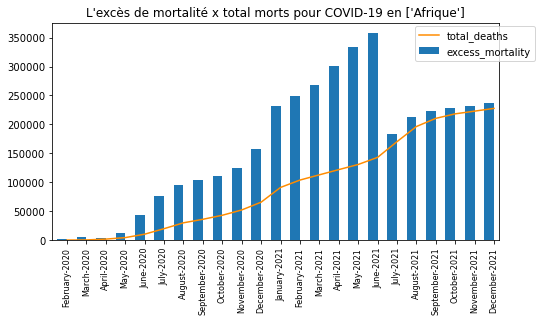

In [34]:
#plot Africa

covid_data_month_excess_af = covid_data_month[covid_data_month['continent'] == 'Africa']
covid_data_month_excess_af = covid_data_month_excess_af[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_af = covid_data_month_excess_af[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_af.columns = ['month_year', 'total_deaths', 'excess_mortality']
covid_data_month_excess_af['continent'] ='Afrique'
covid_data_month_excess_af['month_year'] = covid_data_month_excess_af['month_year'].apply(lambda x: x.strftime('%B-%Y'))

df =  covid_data_month_excess_af.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,4), color='C0')
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 90, fontsize=8)
ax.legend(bbox_to_anchor=(0.8, 0.8))
plt.title("L'excès de mortalité x total morts pour COVID-19 en " + str(df['continent'].unique()))

Text(0.5, 1.0, "['South Africa']")

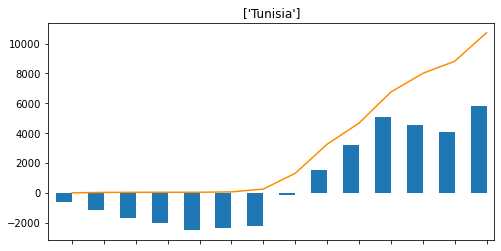

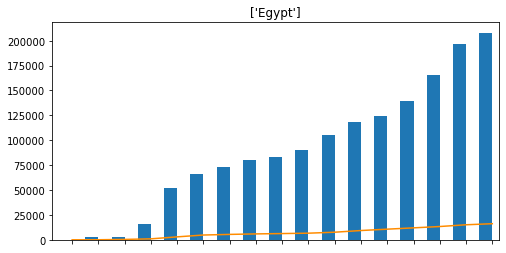

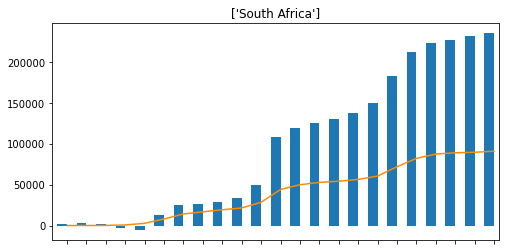

In [35]:
#excès mortalité x morts covid AFRIQUE
#plot Tunisia
covid_data_month_excess_tunisia = covid_data_month_excess[covid_data_month_excess['location'] == 'Tunisia']
covid_data_month_excess_tunisia = covid_data_month_excess_tunisia.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_tunisia['month_year'] = covid_data_month_excess_tunisia['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_tunisia.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,4))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

#plot Egypt
covid_data_month_excess_egypt = covid_data_month_excess[covid_data_month_excess['location'] == 'Egypt']
covid_data_month_excess_egypt = covid_data_month_excess_egypt.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_egypt['month_year'] = covid_data_month_excess_egypt['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_egypt.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,4))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

#plot South Africa
covid_data_month_excess_safrica = covid_data_month_excess[covid_data_month_excess['location'] == 'South Africa']
covid_data_month_excess_safrica = covid_data_month_excess_safrica.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_safrica['month_year'] = covid_data_month_excess_safrica['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_safrica.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,4))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

Text(0.5, 1.0, "['Asie']")

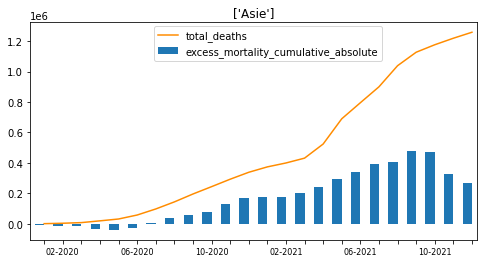

In [36]:
#plot Asie

covid_data_month_excess_asie = covid_data_month[covid_data_month['continent'] == 'Asia']
covid_data_month_excess_asie = covid_data_month_excess_asie[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_asie = covid_data_month_excess_asie[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_asie.columns = ['month_year', 'total_deaths', 'excess_mortality_cumulative_absolute']
covid_data_month_excess_asie['continent'] ='Asie'
covid_data_month_excess_asie['month_year'] = covid_data_month_excess_asie['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_asie['month_year'] = covid_data_month_excess_asie['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})


df =  covid_data_month_excess_asie.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,4))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(0.8, 0.8))
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['continent'].unique()))


Text(0.5, 1.0, "['Mongolia']")

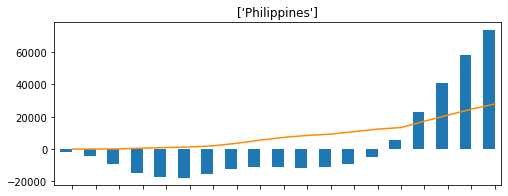

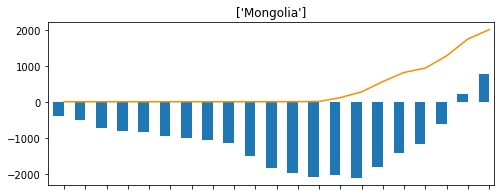

In [37]:
#excès mortalité x morts covid ASIE

#plot Philippines
covid_data_month_excess_philippines = covid_data_month_excess[covid_data_month_excess['location'] == 'Philippines']
covid_data_month_excess_philippines = covid_data_month_excess_philippines.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_philippines['month_year'] = covid_data_month_excess_philippines['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_philippines.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

#plot Mongolia
covid_data_month_excess_mongolia = covid_data_month_excess[covid_data_month_excess['location'] == 'Mongolia']
covid_data_month_excess_mongolia = covid_data_month_excess_mongolia.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_mongolia['month_year'] = covid_data_month_excess_mongolia['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_mongolia.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))


Text(0.5, 1.0, "['Amerique du Sud']")

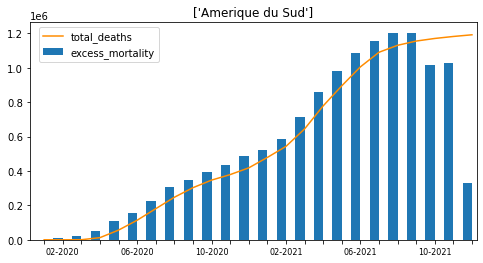

In [38]:
#plot AM sud

covid_data_month_excess_as = covid_data_month[covid_data_month['continent'] == 'South America']
covid_data_month_excess_as = covid_data_month_excess_as[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_as = covid_data_month_excess_as[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_as.columns = ['month_year', 'total_deaths', 'excess_mortality']
covid_data_month_excess_as['continent'] ='Amerique du Sud'
covid_data_month_excess_as['month_year'] = covid_data_month_excess_as['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_as['month_year'] = covid_data_month_excess_as['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})


df =  covid_data_month_excess_as.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,4))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.legend(bbox_to_anchor=(0.3, 1))
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['continent'].unique()))

Text(0.5, 1.0, "['Bolivia']")

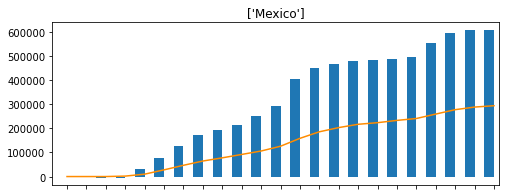

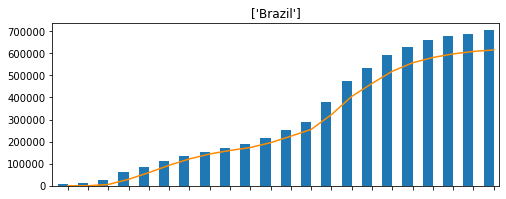

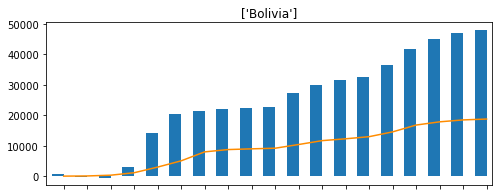

In [39]:
#excès mortalité x morts covid AMERIQUE LATINE

#plot Mexico
covid_data_month_excess_mexico = covid_data_month_excess[covid_data_month_excess['location'] == 'Mexico']
covid_data_month_excess_mexico = covid_data_month_excess_mexico.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_mexico['month_year'] = covid_data_month_excess_mexico['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_mexico.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

#plot Brazil
covid_data_month_excess_bra = covid_data_month_excess[covid_data_month_excess['location'] == 'Brazil']
covid_data_month_excess_bra = covid_data_month_excess_bra.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_bra['month_year'] = covid_data_month_excess_bra['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_bra.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

#plot Bolivia
covid_data_month_excess_bolivia = covid_data_month_excess[covid_data_month_excess['location'] == 'Bolivia']
covid_data_month_excess_bolivia = covid_data_month_excess_bolivia.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_bolivia['month_year'] = covid_data_month_excess_bolivia['month_year'].apply(lambda x: x.strftime('%B-%Y'))
df =  covid_data_month_excess_bolivia.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels('')
plt.title(str(df['location'].unique()))

Text(0.5, 1.0, "['Australia']")

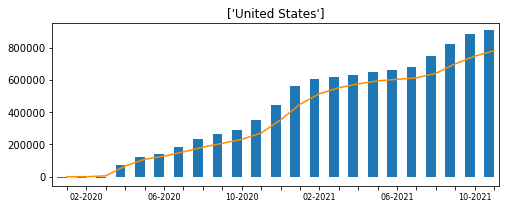

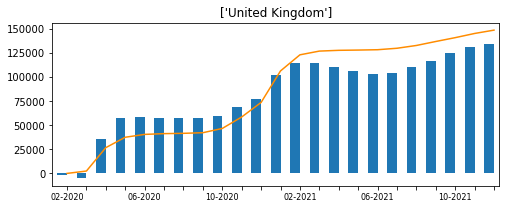

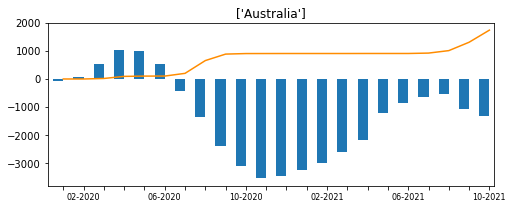

In [40]:
#excès mortalité x morts covid USA X UE X UK

#plot USA
covid_data_month_excess_usa = covid_data_month_excess[covid_data_month_excess['location'] == 'United States']
covid_data_month_excess_usa = covid_data_month_excess_usa.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_usa['month_year'] = covid_data_month_excess_usa['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_usa['month_year'] = covid_data_month_excess_usa['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})

df =  covid_data_month_excess_usa.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['location'].unique()))


#plot UK
covid_data_month_excess_uk = covid_data_month_excess[covid_data_month_excess['location'] == 'United Kingdom']
covid_data_month_excess_uk = covid_data_month_excess_uk.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_uk['month_year'] = covid_data_month_excess_uk['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_uk['month_year'] = covid_data_month_excess_uk['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})



df =  covid_data_month_excess_uk.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['location'].unique()))


#plot autralia
covid_data_month_excess_aus = covid_data_month_excess[covid_data_month_excess['location'] == 'Australia']
covid_data_month_excess_aus = covid_data_month_excess_aus.sort_values('month_year', ascending=True).reset_index()
covid_data_month_excess_aus['month_year'] = covid_data_month_excess_aus['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_aus['month_year'] = covid_data_month_excess_aus['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})

df =  covid_data_month_excess_aus.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality_cumulative_absolute.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['location'].unique()))

Text(0.5, 1.0, "['Océanie']")

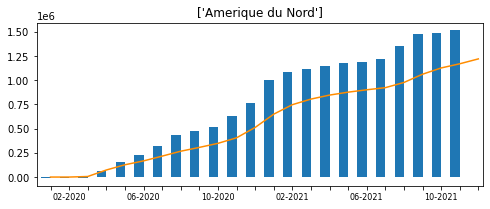

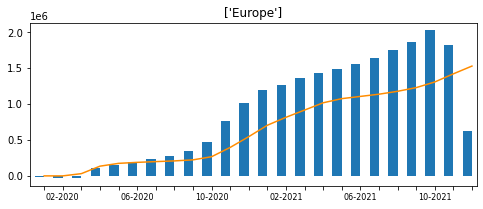

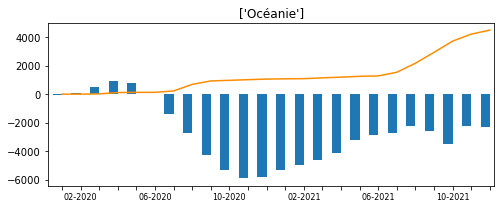

In [41]:
#plot AM Nord

covid_data_month_excess_an = covid_data_month[covid_data_month['continent'] == 'North America']
covid_data_month_excess_an = covid_data_month_excess_an[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_an = covid_data_month_excess_an[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_an.columns = ['month_year', 'total_deaths', 'excess_mortality']
covid_data_month_excess_an['continent'] ='Amerique du Nord'
covid_data_month_excess_an['month_year'] = covid_data_month_excess_an['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_an['month_year'] = covid_data_month_excess_an['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})



df =  covid_data_month_excess_an.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['continent'].unique()))

#plot Europe

covid_data_month_excess_eu = covid_data_month[covid_data_month['continent'] == 'Europe']
covid_data_month_excess_eu = covid_data_month_excess_eu[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_eu = covid_data_month_excess_eu[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_eu.columns = ['month_year', 'total_deaths', 'excess_mortality']
covid_data_month_excess_eu['continent'] ='Europe'
covid_data_month_excess_eu['month_year'] = covid_data_month_excess_eu['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_eu['month_year'] = covid_data_month_excess_eu['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})


df =  covid_data_month_excess_eu.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['continent'].unique()))


#plot oceania

covid_data_month_excess_oc = covid_data_month[covid_data_month['continent'] == 'Oceania']
covid_data_month_excess_oc = covid_data_month_excess_oc[['month_year','location','continent','total_deaths','excess_mortality_cumulative_absolute']]

covid_data_month_excess_oc = covid_data_month_excess_oc[['month_year','continent','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
covid_data_month_excess_oc.columns = ['month_year', 'total_deaths', 'excess_mortality']
covid_data_month_excess_oc['continent'] ='Océanie'
covid_data_month_excess_oc['month_year'] = covid_data_month_excess_oc['month_year'].apply(lambda x: x.strftime('%B-%Y'))
covid_data_month_excess_oc['month_year'] = covid_data_month_excess_oc['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})

df =  covid_data_month_excess_oc.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')
ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['continent'].unique()))

Text(0.5, 1.0, "['Low middle and low income']")

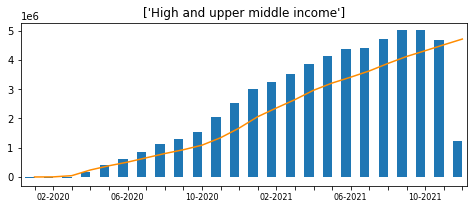

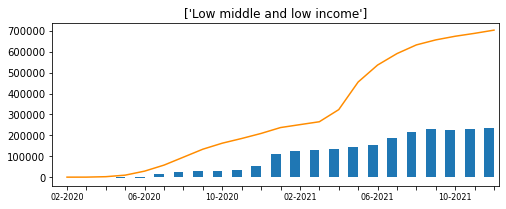

In [42]:
#Création df pour les pays des cluster 1 et 2 du clustering income, soit "high and upper middle income"
#création de la liste de pays à retenir
l_pays_high_moyen_income = l_pays_cluster_income_1 + l_pays_cluster_income_2 
data_AB_income_excess = covid_data_month.copy()
data_AB_income_excess = data_AB_income_excess[data_AB_income_excess.location.isin(l_pays_high_moyen_income)]
data_AB_income_excess['income'] = 'High and upper middle income' 
data_AB_income_excess = data_AB_income_excess[['month_year','income','total_deaths','excess_mortality_cumulative_absolute']]
data_AB_income_excess = data_AB_income_excess[['month_year','income','total_deaths','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'total_deaths': ['sum'], 'excess_mortality_cumulative_absolute':['sum']
}).reset_index()
data_AB_income_excess.columns = ['month_year', 'total_deaths', 'excess_mortality']
data_AB_income_excess['income'] = 'High and upper middle income' 
data_AB_income_excess['month_year'] = data_AB_income_excess['month_year'].apply(lambda x: x.strftime('%B-%Y'))
data_AB_income_excess['month_year'] = data_AB_income_excess['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})

df =  data_AB_income_excess.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')

ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['income'].unique()))




#Création df pour les pays des cluster 3 et 4 du clustering income, soit "Low middle and low income"
#création de la liste de pays à retenir

l_pays_moyen_bas_income = l_pays_cluster_income_3 + l_pays_cluster_income_4 

data_CD_income_excess = covid_data_month.copy()
data_CD_income_excess = data_CD_income_excess[data_CD_income_excess.location.isin(l_pays_moyen_bas_income)]
data_CD_income_excess['income'] ='Low middle and low income'
data_CD_income_excess = data_CD_income_excess[['month_year','location','income','excess_mortality_cumulative_absolute']]
data_CD_income_excess = data_CD_income_excess.reset_index()
data_CD_income_excess= data_CD_income_excess[(data_CD_income_excess['excess_mortality_cumulative_absolute'] != 0)]
data_CD_income_excess = data_CD_income_excess[['month_year','excess_mortality_cumulative_absolute']].groupby('month_year').agg({
    'excess_mortality_cumulative_absolute': ['sum']
    }).reset_index()

data_CD_income_excess.columns = ['month_year','excess_mortality']


df_location_covid_death = covid_data_month.copy()
df_location_covid_death = df_location_covid_death[['month_year','location','total_deaths']]
df_location_covid_death = df_location_covid_death[df_location_covid_death.location.isin(l_pays_moyen_bas_income)]

df_location_covid_death = df_location_covid_death[['month_year','total_deaths']].groupby('month_year').agg({
    'total_deaths': ['sum']
}).reset_index()
df_location_covid_death.columns = ['month_year','total_deaths']

data_CD_income_excess = pd.merge(data_CD_income_excess, df_location_covid_death, on='month_year')

data_CD_income_excess['income'] = 'Low middle and low income'
data_CD_income_excess['month_year'] = data_CD_income_excess['month_year'].apply(lambda x: x.strftime('%B-%Y'))
data_CD_income_excess['month_year'] = data_CD_income_excess['month_year'].replace({'January-2020' : '', 'February-2020' : '02-2020', 'March-2020': '', 'April-2020': '',
       'May-2020': '', 'June-2020': '06-2020', 'July-2020': '', 'August-2020': '',
       'September-2020': '', 'October-2020': '10-2020', 'November-2020': '', 'December-2020': '',
       'January-2021': '', 'February-2021': '02-2021', 'March-2021': '', 'April-2021': '',
       'May-2021': '', 'June-2021': '06-2021', 'July-2021': '', 'August-2021': '',
       'September-2021': '', 'October-2021': '10-2021', 'November-2021': '', 'December-2021': ''})

df =  data_CD_income_excess.copy()
fig = plt.figure() # Create matplotlib figure
ax = fig.add_subplot(111) # Create matplotlib axes
df.excess_mortality.plot(kind='bar', ax=ax, position=1, figsize=(8,3))
df.total_deaths.plot(kind='line', color='darkorange')
ax.set_ylabel('')

ax.set_xticklabels((df['month_year']), rotation = 0, fontsize=8)
plt.title(str(df['income'].unique()))


# ANALYSE DE L'INDICE DE CONTINGENCE

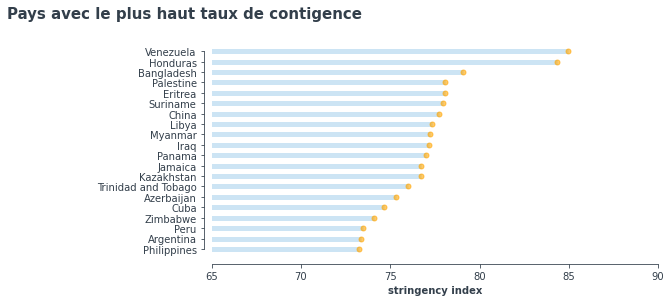

In [43]:
#ranking des pays ayant appliqué des mesures plus strictes
covid_data_month_mesure = covid_data_month.copy()
covid_data_month_mesure = covid_data_month_mesure[['location','month_year', 'stringency_index']]
covid_data_month_mesure = covid_data_month_mesure.groupby([pd.Grouper('location')]).mean()
covid_data_month_mesure = covid_data_month_mesure.sort_values('stringency_index', ascending=False)
covid_data_month_mesure = covid_data_month_mesure.head(20)
covid_data_month_mesure = covid_data_month_mesure.sort_values('stringency_index', ascending=True)


# set the style of the axes and the text color
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['text.color']='#333F4B'


df = covid_data_month_mesure.copy()
# we first need a numeric placeholder for the y axis
my_range=list(range(1,len(df.index)+1))

fig, ax = plt.subplots(figsize=(8,4))

# create for each expense type an horizontal line that starts at x = 0 with the length 
# represented by the specific expense percentage value.
plt.hlines(y=my_range, xmin=0, xmax=df['stringency_index'], color='#007ACC', alpha=0.2, linewidth=5)

# create for each expense type a dot at the level of the expense percentage value
plt.plot(df['stringency_index'], my_range, "o", markersize=5, color='orange', alpha=0.6)

# set labels
ax.set_xlabel('stringency index', fontsize=10, fontweight='black', color = '#333F4B')
ax.set_ylabel('')

# set axis
ax.tick_params(axis='both', which='major', labelsize=10)
plt.yticks(my_range, df.index)

# add an horizonal label for the y axis 
fig.text(-0.23, 0.96, 'Pays avec le plus haut taux de contigence', fontsize=15, fontweight='black', color = '#333F4B')

# change the style of the axis spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_bounds((1, len(my_range)))
ax.set_xlim(65,90)

ax.spines['left'].set_position(('outward', 8))
ax.spines['bottom'].set_position(('outward', 5))

# Annotate
#for row in df.itertuples():
    #ax.text(row.Index, row.stringency_index+.5, s=round(row.stringency_index, 2), horizontalalignment= 'center', verticalalignment='bottom',color='orange', fontsize=14)

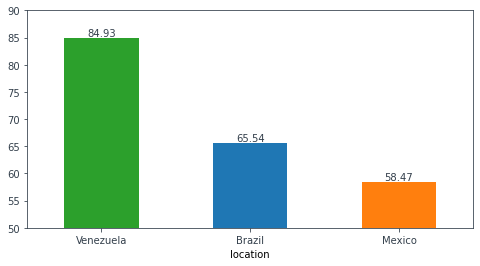

In [44]:
covid_data_month_mesure_am_sud = covid_data_month.copy()
covid_data_month_mesure_am_sud = covid_data_month_mesure_am_sud[['location','month_year', 'stringency_index']]
covid_data_month_mesure_am_sud = covid_data_month_mesure_am_sud[covid_data_month_mesure_am_sud.location.isin(l_pays_am_sud)]
covid_data_month_mesure_am_sud = covid_data_month_mesure_am_sud.groupby([pd.Grouper('location')]).mean()
covid_data_month_mesure_am_sud = covid_data_month_mesure_am_sud.sort_values('stringency_index', ascending=False)
covid_data_month_mesure_am_sud = covid_data_month_mesure_am_sud.reset_index()

plots = covid_data_month_mesure_am_sud.plot.bar(x='location',legend=None, y='stringency_index', color=['C2', 'C0', 'C1'], rot=0, figsize=(8,4))
for bar in plots.patches:   
    plots.annotate(format(bar.get_height(), '.2f'),(bar.get_x() + bar.get_width() / 2, bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 5),textcoords='offset points') 
plots.set_ylim(50, 90)
plt.show()


# ANALYSE DE L'AGE MOYENNE

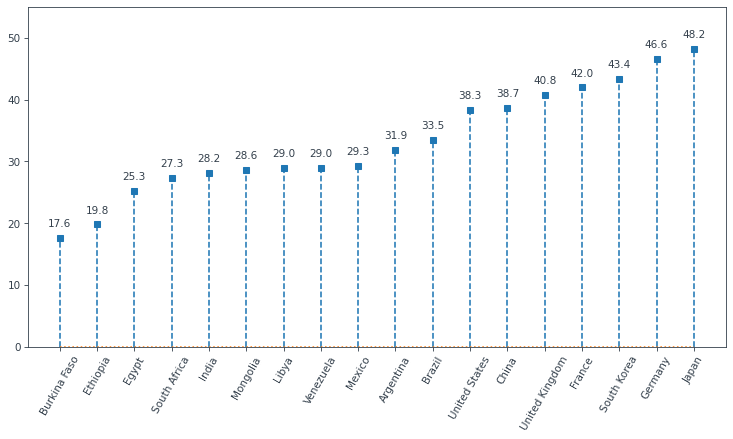

In [45]:
data_age_moyenne = covid_data_month[['location','median_age']]
data_age_moyenne = data_age_moyenne [['location', 'median_age']].groupby('location').mean().reset_index()

l_pays_cluster_covid_age = l_pays_cluster_covid + ['Philipinnes'] + ['Mongolia'] + ['France']+ ['South Korea']+ ['China']+ ['Japan']+ ['Argentina']+ ['South Africa']+ ['Egypt']+ ['Burkina Faso']+ ['Ethiopia']+ ['Venezuela']+ ['Brazil']+ ['United Kingdom']
data_age_moyenne_pays = data_age_moyenne[data_age_moyenne.location.isin(l_pays_cluster_covid_age)]

df = data_age_moyenne_pays.copy()
df.sort_values('median_age', inplace=True)
df.reset_index(inplace=True)

fig, ax = plt.subplots(figsize=(12,6), dpi= 75)
plt.stem(df.location, df.median_age, markerfmt = 's', linefmt='--', basefmt = ':', use_line_collection=True)
ax.set_ylim(0, 55)
for row in df.itertuples():
    ax.text(row.Index, row.median_age+1.5, s=round(row.median_age, 2), horizontalalignment= 'center', verticalalignment='bottom',color='#333F4B', fontsize=10)
plt.xticks(rotation = 60)
plt.show()


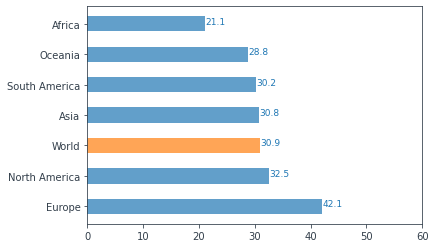

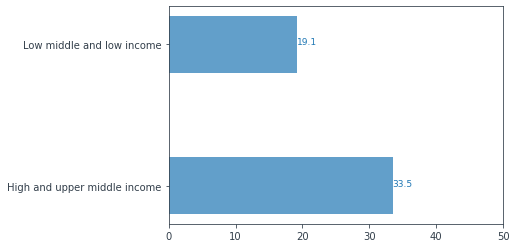

In [46]:
#création d'un df pour vistualisation d'agê moyenne pour income
data_age_moyenne = covid_data_month[['location','median_age']]
data_age_moyenne = data_age_moyenne [['location', 'median_age']].groupby('location').mean().reset_index()

data_age_moyenne_low_income = data_age_moyenne.copy()
data_age_moyenne_low_income = data_age_moyenne_low_income[data_age_moyenne_low_income.location.isin(l_pays_moyen_bas_income)]
data_age_moyenne_low_income['income'] = 'Low middle and low income'

data_age_moyenne_low_income = data_age_moyenne_low_income[['income','median_age']].groupby('income').agg({
    'median_age': ['mean']
    }).reset_index()
data_age_moyenne_low_income.columns = ['income','median_age']


data_age_moyenne_high_income = data_age_moyenne.copy()
data_age_moyenne_high_income = data_age_moyenne_high_income[data_age_moyenne_high_income.location.isin(l_pays_high_moyen_income)]
data_age_moyenne_high_income['income'] = 'High and upper middle income'

data_age_moyenne_high_income = data_age_moyenne_high_income[['income','median_age']].groupby('income').agg({
    'median_age': ['mean']
    }).reset_index()
data_age_moyenne_high_income.columns = ['income','median_age']
frames = (data_age_moyenne_high_income, data_age_moyenne_low_income)
data_age_moyenne_income = pd.concat(frames)

data_age_moyenne_income = data_age_moyenne_income.rename(columns={'income':'continent'})

#création de la liste avec les continents
l_age_continent = covid_data[covid_data['continent'] == 'continent']
l_age_continent = l_age_continent['location']
l_age_continent = l_age_continent.drop_duplicates()
l_age_continent = l_age_continent.tolist()
#df d'age moyenne par continent 
age_continent = covid_data.copy()
age_continent = age_continent[age_continent['continent'] != 'continent']
age_continent = age_continent[age_continent['continent'] != 'income']
age_continent = age_continent[age_continent['continent'] != 'international']
age_continent = age_continent[['continent','median_age']]
age_continent = age_continent [['continent', 'median_age']].groupby('continent').mean().reset_index()
age_continent = age_continent.sort_values('median_age', ascending=False)
#graphique d'age moyenne par continent 
ax = plt.subplot(111)
width=0.5
ax.barh(age_continent.continent, age_continent.median_age, width, align='center', alpha=0.7, color=['C0', 'C0','C1', 'C0', 'C0', 'C0', 'C0']) #a horizontal bar chart (use .bar instead of .barh for vertical)
ax.set_xlim(0, 60)

for i, v in enumerate(age_continent.median_age):
    ax.text(v+0,i-0.0, s =round(v, 1), color='C0', fontsize=9) #the 0.15 and 0.05 were set after trial & error (based on how nice things look)

plt.show()

#graphique d'age moyenne par income 

ax = plt.subplot(111)
width=0.4
ax.barh(data_age_moyenne_income.continent, data_age_moyenne_income.median_age, width, align='center', alpha=0.7, color=['C0', 'C0']) #a horizontal bar chart (use .bar instead of .barh for vertical)
ax.set_xlim(0, 50)

for i, v in enumerate(data_age_moyenne_income.median_age):
    ax.text(v+0,i-0.0, s =round(v, 1), color='C0', fontsize=9) #the 0.15 and 0.05 were set after trial & error (based on how nice things look)

plt.show()

# % POPULATION +65 ET +70

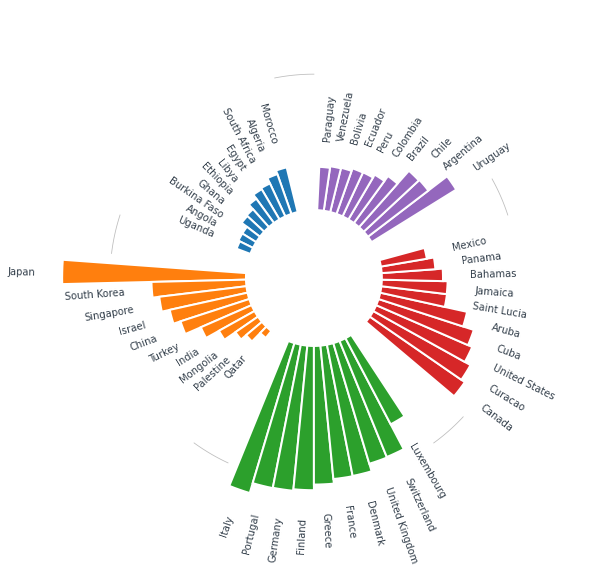

In [47]:
continent_pays = covid_data_month[['continent','location']].drop_duplicates().reset_index()
continent_pays.drop(['index'],  axis=1, inplace=True)

data_older = covid_data_month[['continent','location','aged_65_older', 'aged_70_older']].groupby('location').mean().reset_index()
data_older= data_older[(data_older['aged_65_older'] != 0)&(data_older["aged_70_older"]!= 0)]
data_older = pd.merge(data_older, continent_pays, on='location')
data_older.sort_values('continent', inplace=True)
data_older.reset_index(inplace=True)
data_older.drop(['index'],  axis=1, inplace=True)

l_pays_aged = l_pays_cluster_covid_age + ['Uganda'] + ['Angola'] + ['Morocco']+ ['Algeria']+ ['Ghana']+ ['Qatar']+ ['Singapore']+ ['Turkey']+ ['Israel']+ ['Palestine']+ ['Luxembourg']+ ['Greece']+ ['Finland']+ ['Portugal']+ ['Italy']+ ['Denmark']+ ['Switzerland']+ ['Canada']+ ['Bahamas']+ ['Curacao']+ ['Cuba']+ ['Panama']+ ['Saint Lucia']+ ['Aruba']+ ['Jamaica']+ ['Uruguay']+ ['Chile']+ ['Colombia']+ ['Paraguay']+ ['Bolivia']+ ['Ecuador']+ ['Peru']

data_older['aged_65_69'] = data_older['aged_65_older'] - data_older['aged_70_older']
data_older = data_older[['continent','location','aged_65_69','aged_70_older','aged_65_older']]


data_older_pays = data_older[data_older.location.isin(l_pays_aged)].reset_index()
data_older_pays.drop(['index'],  axis=1, inplace=True)

#data_older[data_older['continent']=='South America'].sort_values('aged_65_older', ascending=True)


def add_labels(angles, values, labels, offset, ax):
    
    # This is the space between the end of the bar and the label
    padding = 4
    
    # Iterate over angles, values, and labels, to add all of them.
    for angle, value, label, in zip(angles, values, labels):
        angle = angle
        
        # Obtain text rotation and alignment
        rotation, alignment = get_label_rotation(angle, offset)

        # And finally add the text
        ax.text(
            x=angle, 
            y=value + padding, 
            s=label, 
            ha=alignment, 
            va="center", 
            rotation=rotation, 
            rotation_mode="anchor"
        ) 
        
        
def get_label_rotation(angle, offset):
    # Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle + offset)
    if angle <= np.pi:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"
    return rotation, alignment



df= data_older_pays.copy()
df.sort_values('continent', inplace=True)
df.reset_index(inplace=True)

df = (
    df
    .groupby(["continent"])
    .apply(lambda x: x.sort_values(["aged_65_older"], ascending = False))
    .reset_index(drop=True)
)


# All this part is like the code above
VALUES = df["aged_65_older"].values
LABELS = df["location"].values
GROUP = df["continent"].values

PAD = 3
ANGLES_N = len(VALUES) + PAD * len(np.unique(GROUP))
ANGLES = np.linspace(0, 2 * np.pi, num=ANGLES_N, endpoint=False)
WIDTH = (2 * np.pi) / len(ANGLES)
OFFSET = np.pi / 2
offset = 0
IDXS = []
GROUPS_SIZE = [10, 10, 10, 10, 10]
for size in GROUPS_SIZE:
    IDXS += list(range(offset + PAD, offset + size + PAD))
    offset += size + PAD

fig, ax = plt.subplots(figsize=(20, 10), subplot_kw={"projection": "polar"})
ax.set_theta_offset(OFFSET)
ax.set_ylim(-10, 30)
ax.set_visible(True)
ax.set_frame_on(False)
ax.xaxis.grid(False)
ax.yaxis.grid(False)
ax.set_xticks([])
ax.set_yticks([])

GROUPS_SIZE = [10, 10, 10, 10, 10]
COLORS = [f"C{i}" for i, size in enumerate(GROUPS_SIZE) for _ in range(size)]

ax.bar(ANGLES[IDXS], VALUES, width=WIDTH, color=COLORS, edgecolor="white", linewidth=2)

add_labels(ANGLES[IDXS], VALUES, LABELS, OFFSET, ax)

# Extra customization below here --------------------

# This iterates over the sizes of the groups adding reference
# lines and annotations.

offset = 0 
for group, size in zip(['Africa','Asia', 'Europe', 'North America', 'South America'], GROUPS_SIZE):
    # Add line below bars
    x1 = np.linspace(ANGLES[offset + PAD], ANGLES[offset + size + PAD - 1], num=50)
    #ax.plot(x1, [-5] * 50, color="#333333")
    
    # Add text to indicate group
    #ax.text(
        #np.mean(x1), -15, group, color="#333333", fontsize=10, 
        #fontweight="bold", ha="center", va='center'
    #)
    
    # Add reference lines at 20, 40, 60, and 80
    x2 = np.linspace(ANGLES[offset], ANGLES[offset + PAD - 1], num=50)
    ax.plot(x2, [20] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [40] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [60] * 50, color="#bebebe", lw=0.8)
    ax.plot(x2, [80] * 50, color="#bebebe", lw=0.8)
    
    offset += size + PAD

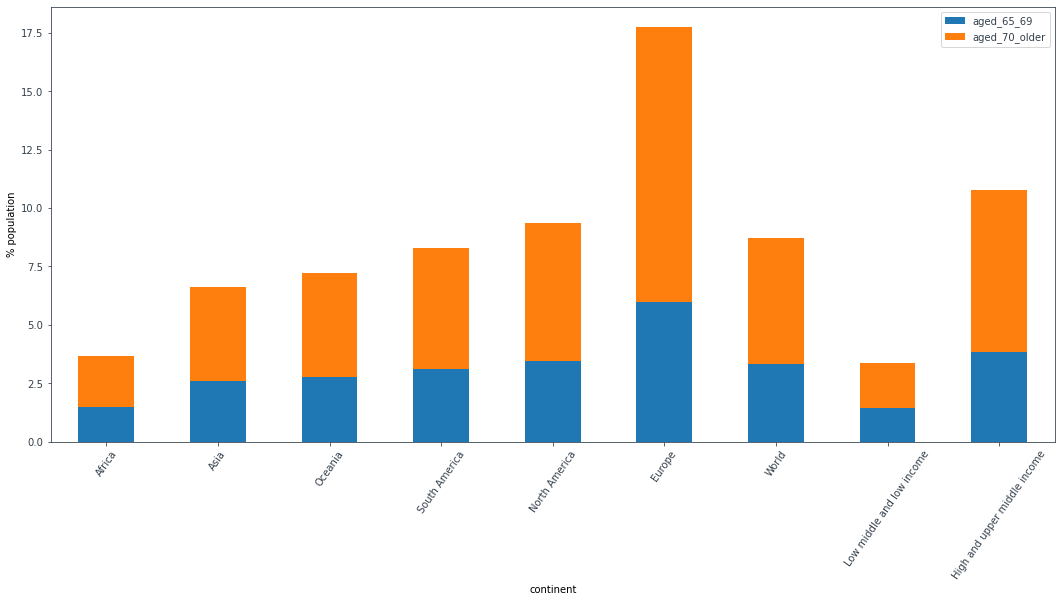

In [48]:
data_older_moyen_bas_income = data_older.copy()

data_older_moyen_bas_income = data_older_moyen_bas_income[data_older_moyen_bas_income.location.isin(l_pays_moyen_bas_income)]
data_older_moyen_bas_income['income'] = 'Low middle and low income'

data_older_moyen_bas_income = data_older_moyen_bas_income[['income','aged_65_69','aged_70_older','aged_65_older']].groupby('income').agg({
    'aged_65_69': ['mean'],'aged_70_older': ['mean'],'aged_65_older': ['mean'],
    }).reset_index()
data_older_moyen_bas_income.columns = ['income','aged_65_69','aged_70_older','aged_65_older']


data_older_moyen_high_income = data_older.copy()
data_older_moyen_high_income = data_older_moyen_high_income[data_older_moyen_high_income.location.isin(l_pays_high_moyen_income)]
data_older_moyen_high_income['income'] = 'High and upper middle income'

data_older_moyen_high_income = data_older_moyen_high_income[['income','aged_65_69','aged_70_older','aged_65_older']].groupby('income').agg({
    'aged_65_69': ['mean'],'aged_70_older': ['mean'],'aged_65_older': ['mean'],
    }).reset_index()
data_older_moyen_high_income.columns = ['income','aged_65_69','aged_70_older','aged_65_older']
frames = (data_older_moyen_high_income, data_older_moyen_bas_income)
data_older_income = pd.concat(frames)

data_older_income = data_older_income.rename(columns={'income':'continent'})
data_older_income = data_older_income.reset_index()
data_older_income.drop(['index'],  axis=1, inplace=True)

#df d'age moyenne par continent 
data_older_continent = data_older.copy()
data_older_continent = data_older_continent[data_older_continent['continent'] != 'continent']
data_older_continent = data_older_continent[data_older_continent['continent'] != 'income']
data_older_continent = data_older_continent[data_older_continent['continent'] != 'international']
data_older_continent = data_older_continent[['continent','aged_65_69','aged_70_older','aged_65_older']].groupby('continent').agg({
    'aged_65_69': ['mean'],'aged_70_older': ['mean'],'aged_65_older': ['mean'],
    }).reset_index()
data_older_continent.columns = ['continent','aged_65_69','aged_70_older','aged_65_older']


frame_age = (data_older_income, data_older_continent)
data_older_income_continent = pd.concat(frame_age)
data_older_income_continent['rang'] = ['9','8','1','2','6','5','3','4','7']
data_older_income_continent = data_older_income_continent.sort_values('rang', ascending=True)

df= data_older_income_continent.copy()


df.plot.bar(x='continent',  y=["aged_65_69", "aged_70_older"], rot=0, figsize=(18,8), stacked=True)
plt.ylabel('% population')
plt.xticks(rotation = 55)
plt.show()


# ANALYSE DES COMORBITES

In [49]:
comorbidite = covid_data_month[['location', 'cardiovasc_death_rate','diabetes_prevalence', 'female_smokers','male_smokers']]

comorbidite_pays = comorbidite[comorbidite.location.isin(l_pays_cluster_covid_age)].reset_index()
comorbidite_pays.drop(['index'],  axis=1, inplace=True)
comorbidite_pays = comorbidite_pays.drop_duplicates()
comorbidite_pays = comorbidite_pays.sort_values('cardiovasc_death_rate', ascending=True)
comorbidite_pays

,location,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers
0,Japan,79.37,5.72,11.20,33.70
9,South Korea,86.00,6.80,6.20,40.90
5,France,86.06,4.77,30.10,35.60
8,United Kingdom,122.14,4.28,20.00,24.70
7,United States,151.09,10.79,19.10,24.60
6,Mexico,152.78,13.06,6.90,21.40
2,Germany,156.14,8.31,28.20,33.10
17,Brazil,177.96,8.11,10.10,17.90
38,Ethiopia,182.63,7.47,0.40,8.50
4,Argentina,191.03,5.50,16.20,27.70


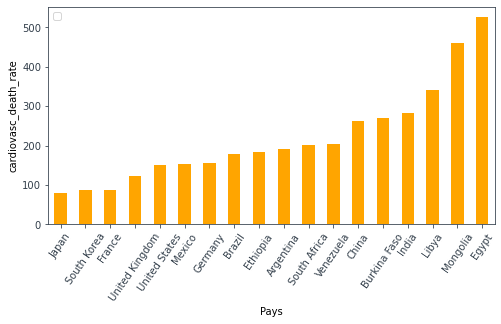

In [50]:
#graphique cardiovasc_death_rate pour les pays dans la liste
comorbidite_pays = comorbidite_pays.sort_values('cardiovasc_death_rate', ascending=True)
comorbidite_pays.plot.bar(x='location', y='cardiovasc_death_rate', rot=0, figsize=(8,4), color = 'orange')
plt.xlabel('Pays')
plt.xticks(rotation = 55)
plt.ylabel('cardiovasc_death_rate')
plt.legend('')
plt.show()

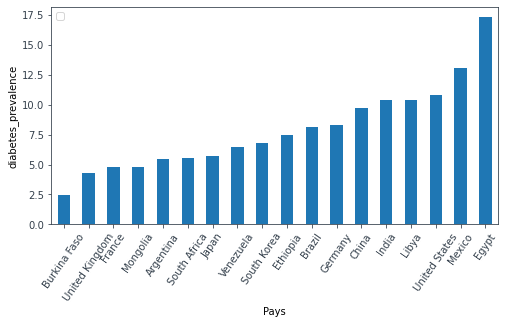

In [51]:
#graphique diabetes_prevalence pour les pays dans la liste
comorbidite_pays = comorbidite_pays.sort_values('diabetes_prevalence', ascending=True)

comorbidite_pays.plot.bar(x='location', y='diabetes_prevalence', rot=0, figsize=(8,4))
plt.xlabel('Pays')
plt.xticks(rotation = 55)
plt.ylabel('diabetes_prevalence')
plt.legend('')
plt.show()

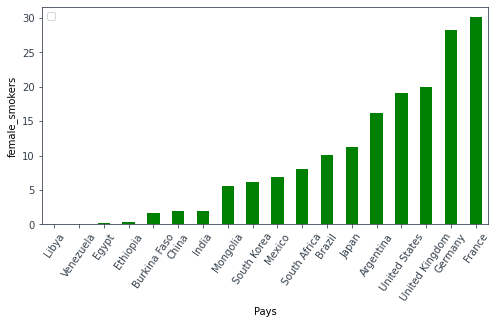

In [52]:
#graphique female_smokers pour les pays dans la liste
comorbidite_pays = comorbidite_pays.sort_values('female_smokers', ascending=True)

comorbidite_pays.plot.bar(x='location', y='female_smokers', rot=0, figsize=(8,4), color = 'green')
plt.xlabel('Pays')
plt.xticks(rotation = 55)
plt.ylabel('female_smokers')
plt.legend('')
plt.show()

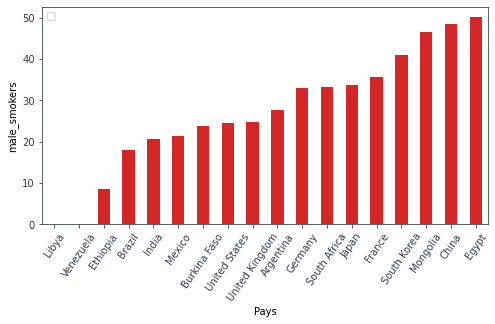

In [53]:
#graphique male_smokers pour les pays dans la liste
comorbidite_pays = comorbidite_pays.sort_values('male_smokers', ascending=True)
l_pays_cluster_covid_age
comorbidite_pays.plot.bar(x='location', y='male_smokers', rot=0, figsize=(8,4), color = 'C3')
plt.xlabel('Pays')
plt.xticks(rotation = 55)
plt.ylabel('male_smokers')
plt.legend('')
plt.show()

# ANALYSE VACCIN

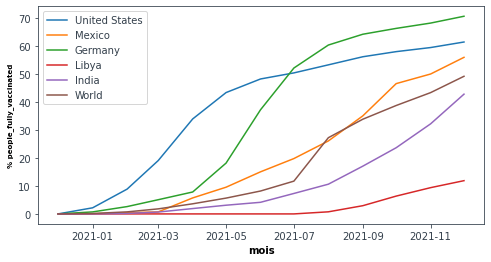

In [54]:
vaccin = covid_data_month.copy() 
vaccin = vaccin[['continent','location','month_year','people_fully_vaccinated','population']]
vaccin['perc_tot_vac'] = vaccin['people_fully_vaccinated'] / vaccin['population']*100
vaccin = vaccin[(vaccin['month_year'] > '2020-11-01') & (vaccin['month_year'] < '2021-12-31')]


#Affichage de l'évolution de la vaccination pour les centroides du clustering - Covid
fig = plt.figure(figsize=(8,4))
for x in cluster_covid_pays_list_world: 
    data = vaccin.copy()
    data = data[data['location'] == x]
    plt.plot(data['month_year'], (data['perc_tot_vac']), label=x)
    plt.xlabel("mois", fontsize=10, fontweight='bold')
    plt.ylabel("% people_fully_vaccinated", fontsize=7, fontweight='bold')
    plt.legend()    


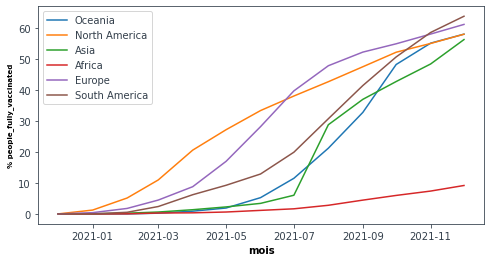

In [55]:
#Affichage de l'évolution de la vaccination par continent
fig = plt.figure(figsize=(8,4))

continent_data = vaccin[vaccin['continent'] == 'continent']

l_continent_data = continent_data['location']
l_continent_data = l_continent_data.drop_duplicates()
l_continent_data = l_continent_data.tolist()

for x in l_continent_data: 
    data = vaccin.copy()
    data = data[data['location'] == x]
    plt.plot(data['month_year'], (data['perc_tot_vac']), label=x)
    plt.xlabel("mois", fontsize=10, fontweight='bold')
    plt.ylabel("% people_fully_vaccinated", fontsize=7, fontweight='bold')
    plt.legend() 

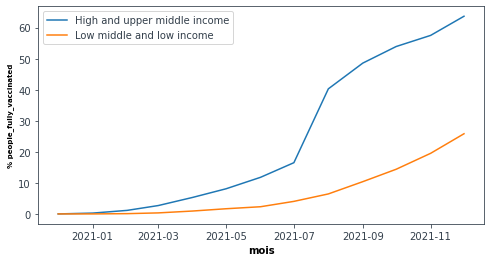

In [56]:
#Création df vaccination pour les pays riches et moyennement riches
high_income_data = vaccin.copy()
high_income_data = high_income_data[high_income_data.location.isin(l_pays_high_moyen_income)]
high_income_data['income'] = 'High and upper middle income'

high_income_data_pop = high_income_data[['month_year','population']].groupby('month_year').agg({
    'population': ['sum']
    }).reset_index()
high_income_data_pop.columns = ['month_year','population']
high_income_data_vac = high_income_data[['month_year','people_fully_vaccinated']].groupby('month_year').agg({
    'people_fully_vaccinated': ['sum']
    }).reset_index()
high_income_data_vac.columns = ['month_year','people_fully_vaccinated']

high_income_data = pd.merge(high_income_data_pop,high_income_data_vac, on='month_year')

high_income_data['income'] = 'High and upper middle income'
high_income_data['perc_tot_vac'] =  high_income_data['people_fully_vaccinated'] / high_income_data['population']*100
high_income_data =high_income_data[['month_year','income', 'perc_tot_vac']] 


#Création df vaccination pour les pays moyennement pauvres et pauvres
low_income_data = vaccin.copy()
low_income_data = low_income_data[low_income_data.location.isin(l_pays_moyen_bas_income)]
low_income_data['income'] = 'Low middle and low income'

low_income_data_pop = low_income_data[['month_year','population']].groupby('month_year').agg({
    'population': ['sum']
    }).reset_index()
low_income_data_pop.columns = ['month_year','population']
low_income_data_vac = low_income_data[['month_year','people_fully_vaccinated']].groupby('month_year').agg({
    'people_fully_vaccinated': ['sum']
    }).reset_index()
low_income_data_vac.columns = ['month_year','people_fully_vaccinated']

low_income_data = pd.merge(low_income_data_pop,low_income_data_vac, on='month_year')

low_income_data['income'] = 'Low middle and low income'
low_income_data['perc_tot_vac'] =  low_income_data['people_fully_vaccinated'] / low_income_data['population']*100
low_income_data =low_income_data[['month_year','income', 'perc_tot_vac']] 

#concatenation des deux dfs income vaccination par mois 
frames = (high_income_data, low_income_data)
data_age_moyenne_income = pd.concat(frames)

#création de liste des incomes
l_income = ['High and upper middle income'] + ['Low middle and low income']

#graphique par mois de l'évolution de la vaccination pour classe de revenu
fig = plt.figure(figsize=(8,4))
for x in l_income: 
    data = data_age_moyenne_income.copy()
    data = data[data['income'] == x]
    plt.plot(data['month_year'], (data['perc_tot_vac']), label=x)
    plt.xlabel("mois", fontsize=10, fontweight='bold')
    plt.ylabel("% people_fully_vaccinated", fontsize=7, fontweight='bold')
    plt.legend() 